# Movie Embedding 품질 검증 및 시각화

CARTE 임베딩이 영화의 의미적 특성을 잘 반영하는지 다각도로 검증합니다.

## 검증 항목
1. **기본 통계**: 임베딩 분포, 노름, 분산 분석
2. **클러스터링 품질**: 장르/감독/배우별 Silhouette Score, 그룹 내/간 유사도
3. **그룹별 시각화**: 각 그룹별 개별 t-SNE 플롯
4. **유사 영화 분석**: 전체 피처 비교로 유사도 원인 추적

In [44]:
import sys
sys.path.insert(0, "/Users/jisoo/projects/thesis/carte_test")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.spatial.distance import cdist
from collections import Counter
from IPython.display import display, HTML

from config import PROCESSED

# 한글 폰트 설정 (macOS)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100

# Pandas 출력 설정
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.width', None)

print("Imports done")

Imports done


---
## 1. 데이터 로드

In [45]:
# 임베딩 로드
df_emb = pd.read_parquet(PROCESSED.MOVIE_EMBEDDINGS_PARQUET)
print(f"Embeddings: {len(df_emb):,} movies")

# 카탈로그 로드 (메타데이터)
df_cat = pd.read_parquet(PROCESSED.MOVIE_CATALOG_PARQUET)
print(f"Catalog: {len(df_cat):,} movies")

# 임베딩을 numpy array로 변환
movie_ids = df_emb["movieId"].values
embeddings = np.vstack(df_emb["embedding"].values).astype(np.float32)
print(f"Embedding shape: {embeddings.shape}")

# 카탈로그와 조인
df = df_emb.merge(df_cat, on="movieId", how="left")
print(f"Merged: {len(df):,} movies")

# 피처 컬럼 정의
FEATURE_COLS = [
    'original_title', 'release_year', 'tagline', 'overview',
    'genre_1', 'genre_2', 'genre_3',
    'director_1', 'writer_1',
    'actor_1', 'actor_2', 'actor_3',
    'produced_by_company_1', 'produced_by_company_2',
    'produced_in_country_1', 'spoken_language_1'
]

# 실제로 존재하는 컬럼만 사용
FEATURE_COLS = [c for c in FEATURE_COLS if c in df.columns]
print(f"\nFeature columns: {FEATURE_COLS}")

Embeddings: 86,272 movies
Catalog: 86,272 movies
Embedding shape: (86272, 300)
Merged: 86,272 movies

Feature columns: ['original_title', 'release_year', 'tagline', 'overview', 'genre_1', 'genre_2', 'genre_3', 'director_1', 'writer_1', 'actor_1', 'actor_2', 'actor_3', 'produced_by_company_1', 'produced_by_company_2', 'produced_in_country_1', 'spoken_language_1']


---
## 2. 임베딩 기본 통계

임베딩 벡터의 분포 특성을 확인합니다.

In [46]:
# 기본 통계량
print("=" * 60)
print("임베딩 기본 통계")
print("=" * 60)

# 각 차원별 통계
dim_means = embeddings.mean(axis=0)
dim_stds = embeddings.std(axis=0)
dim_mins = embeddings.min(axis=0)
dim_maxs = embeddings.max(axis=0)

print(f"\n차원별 평균의 범위: [{dim_means.min():.4f}, {dim_means.max():.4f}]")
print(f"차원별 표준편차 범위: [{dim_stds.min():.4f}, {dim_stds.max():.4f}]")
print(f"전체 값 범위: [{embeddings.min():.4f}, {embeddings.max():.4f}]")

# L2 노름 분포
norms = np.linalg.norm(embeddings, axis=1)
print(f"\nL2 노름 통계:")
print(f"  평균: {norms.mean():.4f}")
print(f"  표준편차: {norms.std():.4f}")
print(f"  범위: [{norms.min():.4f}, {norms.max():.4f}]")

# 분산 분석
total_var = embeddings.var()
per_dim_var = embeddings.var(axis=0)
print(f"\n분산 분석:")
print(f"  전체 분산: {total_var:.6f}")
print(f"  차원별 분산 평균: {per_dim_var.mean():.6f}")
print(f"  유효 차원 수 (분산 > 0.001): {(per_dim_var > 0.001).sum()}")

임베딩 기본 통계

차원별 평균의 범위: [-1.7952, 1.9319]
차원별 표준편차 범위: [0.0088, 0.4087]
전체 값 범위: [-2.6762, 2.6705]

L2 노름 통계:
  평균: 13.4286
  표준편차: 0.2182
  범위: [11.2107, 14.5162]

분산 분석:
  전체 분산: 0.600957
  차원별 분산 평균: 0.029818
  유효 차원 수 (분산 > 0.001): 298


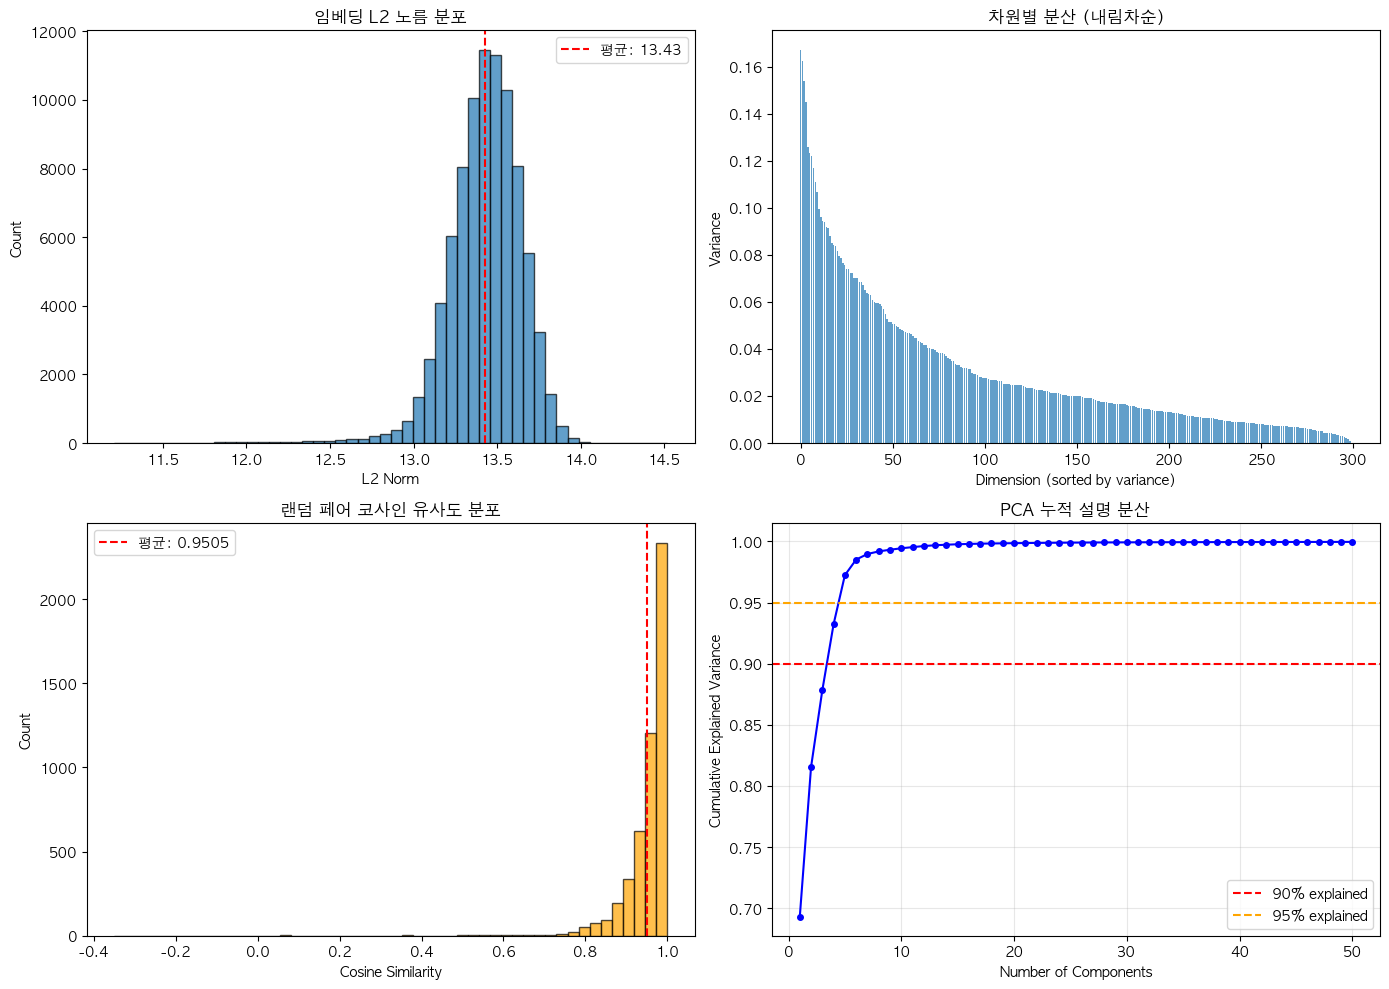


90% 분산 설명에 필요한 차원: 4
95% 분산 설명에 필요한 차원: 5


In [47]:
# 시각화: 임베딩 분포
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. L2 노름 분포
ax = axes[0, 0]
ax.hist(norms, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(norms.mean(), color='red', linestyle='--', label=f'평균: {norms.mean():.2f}')
ax.set_xlabel('L2 Norm')
ax.set_ylabel('Count')
ax.set_title('임베딩 L2 노름 분포')
ax.legend()

# 2. 차원별 분산
ax = axes[0, 1]
ax.bar(range(len(per_dim_var)), sorted(per_dim_var, reverse=True), alpha=0.7)
ax.set_xlabel('Dimension (sorted by variance)')
ax.set_ylabel('Variance')
ax.set_title('차원별 분산 (내림차순)')

# 3. 랜덤 샘플 간 코사인 유사도 분포
ax = axes[1, 0]
np.random.seed(42)
sample_size = 5000
idx1 = np.random.choice(len(embeddings), sample_size, replace=False)
idx2 = np.random.choice(len(embeddings), sample_size, replace=False)

# 코사인 유사도 계산 (정규화된 내적)
emb_norm = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-8)
random_sims = np.sum(emb_norm[idx1] * emb_norm[idx2], axis=1)

ax.hist(random_sims, bins=50, edgecolor='black', alpha=0.7, color='orange')
ax.axvline(random_sims.mean(), color='red', linestyle='--', 
           label=f'평균: {random_sims.mean():.4f}')
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Count')
ax.set_title('랜덤 페어 코사인 유사도 분포')
ax.legend()

# 4. PCA 설명 분산 (누적)
ax = axes[1, 1]
pca_full = PCA(n_components=50, random_state=42)
pca_full.fit(embeddings)
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
ax.plot(range(1, 51), cumsum, 'b-o', markersize=4)
ax.axhline(0.9, color='red', linestyle='--', label='90% explained')
ax.axhline(0.95, color='orange', linestyle='--', label='95% explained')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Explained Variance')
ax.set_title('PCA 누적 설명 분산')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 90%, 95% 설명에 필요한 차원 수
n_90 = np.argmax(cumsum >= 0.9) + 1
n_95 = np.argmax(cumsum >= 0.95) + 1
print(f"\n90% 분산 설명에 필요한 차원: {n_90}")
print(f"95% 분산 설명에 필요한 차원: {n_95}")

---
## 3. 클러스터링 품질 분석

장르, 감독, 배우별로 임베딩이 잘 그룹화되어 있는지 확인합니다.

In [48]:
def compute_group_similarity_stats(embeddings: np.ndarray, labels: np.ndarray, 
                                    group_name: str, top_k: int = 10):
    """
    그룹별 유사도 통계를 계산합니다.
    
    Args:
        embeddings: 정규화된 임베딩 (N, D)
        labels: 그룹 레이블 (N,)
        group_name: 분석 대상 이름 (출력용)
        top_k: 상위 k개 그룹만 분석
    
    Returns:
        dict: 통계 결과
    """
    # Unknown/None 제외
    valid_mask = pd.notna(labels) & (labels != 'Unknown') & (labels != '')
    valid_labels = labels[valid_mask]
    valid_emb = embeddings[valid_mask]
    
    # 상위 그룹 선택
    label_counts = Counter(valid_labels)
    top_groups = [g for g, _ in label_counts.most_common(top_k)]
    
    print(f"\n{'='*60}")
    print(f"{group_name} 클러스터링 분석")
    print(f"{'='*60}")
    print(f"총 유효 샘플: {len(valid_labels):,}")
    print(f"고유 그룹 수: {len(label_counts):,}")
    print(f"\n상위 {top_k}개 그룹 분포:")
    for g, cnt in label_counts.most_common(top_k):
        print(f"  - {g}: {cnt:,} ({cnt/len(valid_labels)*100:.1f}%)")
    
    # 각 그룹의 그룹 내 평균 유사도
    intra_similarities = {}
    group_centroids = {}
    
    for group in top_groups:
        mask = valid_labels == group
        group_emb = valid_emb[mask]
        
        if len(group_emb) < 2:
            continue
        
        # 그룹 중심
        centroid = group_emb.mean(axis=0)
        centroid = centroid / (np.linalg.norm(centroid) + 1e-8)
        group_centroids[group] = centroid
        
        # 그룹 내 평균 유사도 (샘플링)
        if len(group_emb) > 100:
            np.random.seed(42)
            sample_idx = np.random.choice(len(group_emb), 100, replace=False)
            group_emb_sample = group_emb[sample_idx]
        else:
            group_emb_sample = group_emb
        
        sim_matrix = group_emb_sample @ group_emb_sample.T
        # 대각선 제외
        n = len(group_emb_sample)
        intra_sim = (sim_matrix.sum() - n) / (n * (n - 1))
        intra_similarities[group] = intra_sim
    
    # 그룹 간 평균 유사도
    if len(group_centroids) >= 2:
        centroid_matrix = np.vstack(list(group_centroids.values()))
        inter_sim_matrix = centroid_matrix @ centroid_matrix.T
        n_groups = len(centroid_matrix)
        inter_sim = (inter_sim_matrix.sum() - n_groups) / (n_groups * (n_groups - 1))
    else:
        inter_sim = 0
    
    # 결과 출력
    print(f"\n그룹별 내부 평균 코사인 유사도:")
    for group, sim in sorted(intra_similarities.items(), key=lambda x: -x[1]):
        print(f"  - {group}: {sim:.4f}")
    
    avg_intra = np.mean(list(intra_similarities.values())) if intra_similarities else 0
    print(f"\n평균 그룹 내 유사도: {avg_intra:.4f}")
    print(f"그룹 간 중심 유사도: {inter_sim:.4f}")
    print(f"분리도 (intra/inter ratio): {avg_intra/inter_sim:.4f}" if inter_sim > 0 else "N/A")
    
    return {
        'intra_similarities': intra_similarities,
        'inter_similarity': inter_sim,
        'avg_intra': avg_intra,
        'group_centroids': group_centroids
    }

In [49]:
# 임베딩 정규화 (코사인 유사도용)
emb_normalized = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-8)

# 장르별 분석
genre_stats = compute_group_similarity_stats(
    emb_normalized, 
    df['genre_1'].fillna('Unknown').values,
    '장르(genre_1)',
    top_k=15
)


장르(genre_1) 클러스터링 분석
총 유효 샘플: 85,476
고유 그룹 수: 19

상위 15개 그룹 분포:
  - Drama: 22,256 (26.0%)
  - Comedy: 16,611 (19.4%)
  - Documentary: 9,073 (10.6%)
  - Action: 6,326 (7.4%)
  - Horror: 5,755 (6.7%)
  - Animation: 3,555 (4.2%)
  - Thriller: 3,522 (4.1%)
  - Crime: 3,223 (3.8%)
  - Romance: 2,777 (3.2%)
  - Adventure: 2,301 (2.7%)
  - Science Fiction: 1,649 (1.9%)
  - Family: 1,468 (1.7%)
  - Music: 1,154 (1.4%)
  - Mystery: 1,144 (1.3%)
  - Western: 1,140 (1.3%)

그룹별 내부 평균 코사인 유사도:
  - Western: 0.9707
  - Family: 0.9682
  - Horror: 0.9679
  - Drama: 0.9634
  - Thriller: 0.9620
  - Action: 0.9604
  - Adventure: 0.9599
  - Comedy: 0.9594
  - Science Fiction: 0.9570
  - Romance: 0.9566
  - Crime: 0.9538
  - Animation: 0.9473
  - Music: 0.9467
  - Mystery: 0.9399
  - Documentary: 0.9365

평균 그룹 내 유사도: 0.9566
그룹 간 중심 유사도: 0.9921
분리도 (intra/inter ratio): 0.9642


In [50]:
# 감독별 분석 (영화 10편 이상인 감독만)
if 'director_1' in df.columns:
    director_counts = df['director_1'].value_counts()
    frequent_directors = director_counts[director_counts >= 10].index.tolist()
    
    # 빈도 높은 감독의 영화만 필터링
    director_mask = df['director_1'].isin(frequent_directors)
    
    director_stats = compute_group_similarity_stats(
        emb_normalized[director_mask],
        df.loc[director_mask, 'director_1'].values,
        '감독(director_1, 10편 이상)',
        top_k=15
    )


감독(director_1, 10편 이상) 클러스터링 분석
총 유효 샘플: 24,856
고유 그룹 수: 1,374

상위 15개 그룹 분포:
  - Georges Méliès: 118 (0.5%)
  - Chuck Jones: 102 (0.4%)
  - Friz Freleng: 100 (0.4%)
  - Tex Avery: 86 (0.3%)
  - Michael Curtiz: 77 (0.3%)
  - John Ford: 70 (0.3%)
  - Richard Thorpe: 64 (0.3%)
  - Jean-Luc Godard: 62 (0.2%)
  - Werner Herzog: 62 (0.2%)
  - Charlie Chaplin: 62 (0.2%)
  - David DeCoteau: 60 (0.2%)
  - Jack Hannah: 58 (0.2%)
  - Alfred Hitchcock: 56 (0.2%)
  - William Beaudine: 56 (0.2%)
  - Gordon Douglas: 56 (0.2%)

그룹별 내부 평균 코사인 유사도:
  - Charlie Chaplin: 0.9935
  - Jack Hannah: 0.9901
  - William Beaudine: 0.9897
  - Michael Curtiz: 0.9880
  - Richard Thorpe: 0.9879
  - Gordon Douglas: 0.9866
  - Chuck Jones: 0.9853
  - Alfred Hitchcock: 0.9813
  - Jean-Luc Godard: 0.9799
  - Georges Méliès: 0.9790
  - John Ford: 0.9784
  - Tex Avery: 0.9759
  - Friz Freleng: 0.9745
  - David DeCoteau: 0.9736
  - Werner Herzog: 0.9545

평균 그룹 내 유사도: 0.9812
그룹 간 중심 유사도: 0.9799
분리도 (intra/inter ratio): 1.0

In [51]:
# 주연 배우별 분석 (영화 10편 이상인 배우만)
if 'actor_1' in df.columns:
    actor_counts = df['actor_1'].value_counts()
    frequent_actors = actor_counts[actor_counts >= 10].index.tolist()
    
    actor_mask = df['actor_1'].isin(frequent_actors)
    
    actor_stats = compute_group_similarity_stats(
        emb_normalized[actor_mask],
        df.loc[actor_mask, 'actor_1'].values,
        '주연배우(actor_1, 10편 이상)',
        top_k=15
    )


주연배우(actor_1, 10편 이상) 클러스터링 분석
총 유효 샘플: 25,096
고유 그룹 수: 1,322

상위 15개 그룹 분포:
  - Mel Blanc: 232 (0.9%)
  - Clarence Nash: 116 (0.5%)
  - John Wayne: 106 (0.4%)
  - Nicolas Cage: 78 (0.3%)
  - Charlie Chaplin: 76 (0.3%)
  - Georges Méliès: 72 (0.3%)
  - Jackie Chan: 66 (0.3%)
  - Akshay Kumar: 65 (0.3%)
  - Pinto Colvig: 61 (0.2%)
  - Robert De Niro: 59 (0.2%)
  - Stan Laurel: 58 (0.2%)
  - Isabelle Huppert: 57 (0.2%)
  - Barbara Stanwyck: 57 (0.2%)
  - Burt Reynolds: 57 (0.2%)
  - Michael Caine: 56 (0.2%)

그룹별 내부 평균 코사인 유사도:
  - Stan Laurel: 0.9918
  - Georges Méliès: 0.9901
  - Charlie Chaplin: 0.9882
  - Mel Blanc: 0.9874
  - Pinto Colvig: 0.9864
  - Akshay Kumar: 0.9863
  - John Wayne: 0.9848
  - Barbara Stanwyck: 0.9844
  - Clarence Nash: 0.9840
  - Michael Caine: 0.9793
  - Nicolas Cage: 0.9791
  - Robert De Niro: 0.9770
  - Isabelle Huppert: 0.9759
  - Jackie Chan: 0.9747
  - Burt Reynolds: 0.9703

평균 그룹 내 유사도: 0.9826
그룹 간 중심 유사도: 0.9757
분리도 (intra/inter ratio): 1.0071


In [52]:
# 연대별 분석
if 'release_year' in df.columns:
    df['decade'] = (df['release_year'] // 10 * 10).astype('Int64').astype(str) + 's'
    df.loc[df['release_year'].isna(), 'decade'] = 'Unknown'
    
    decade_stats = compute_group_similarity_stats(
        emb_normalized,
        df['decade'].values,
        '연대(decade)',
        top_k=12
    )


연대(decade) 클러스터링 분석
총 유효 샘플: 86,237
고유 그룹 수: 16

상위 12개 그룹 분포:
  - 2010s: 27,751 (32.2%)
  - 2000s: 15,193 (17.6%)
  - 1990s: 8,103 (9.4%)
  - 2020s: 8,065 (9.4%)
  - 1980s: 6,293 (7.3%)
  - 1970s: 5,941 (6.9%)
  - 1960s: 4,348 (5.0%)
  - 1950s: 3,605 (4.2%)
  - 1940s: 2,757 (3.2%)
  - 1930s: 2,584 (3.0%)
  - 1920s: 721 (0.8%)
  - 1910s: 382 (0.4%)

그룹별 내부 평균 코사인 유사도:
  - 2020s: 0.9835
  - 2010s: 0.9826
  - 1910s: 0.9747
  - 2000s: 0.9742
  - 1950s: 0.9718
  - 1980s: 0.9698
  - 1940s: 0.9697
  - 1970s: 0.9679
  - 1960s: 0.9648
  - 1930s: 0.9634
  - 1920s: 0.9562
  - 1990s: 0.9405

평균 그룹 내 유사도: 0.9682
그룹 간 중심 유사도: 0.9770
분리도 (intra/inter ratio): 0.9911


In [53]:
# Silhouette Score 계산 (장르 기준)
# 샘플링해서 계산 (전체는 너무 오래 걸림)
print("\n" + "="*60)
print("Silhouette Score 분석 (장르 기준)")
print("="*60)

# 유효한 장르만
genre_valid_mask = df['genre_1'].notna() & (df['genre_1'] != 'Unknown')
valid_idx = np.where(genre_valid_mask)[0]

# 샘플링
np.random.seed(42)
sample_size = min(10000, len(valid_idx))
sample_idx = np.random.choice(valid_idx, sample_size, replace=False)

sample_emb = emb_normalized[sample_idx]
sample_labels = df.iloc[sample_idx]['genre_1'].values

# Label encoding
le = LabelEncoder()
encoded_labels = le.fit_transform(sample_labels)

# Silhouette score
sil_score = silhouette_score(sample_emb, encoded_labels, metric='cosine')
print(f"\n전체 Silhouette Score: {sil_score:.4f}")
print("(0에 가까우면 클러스터 겹침, 1에 가까우면 잘 분리됨)")

# 장르별 silhouette score
sil_samples = silhouette_samples(sample_emb, encoded_labels, metric='cosine')

genre_sil_scores = {}
for genre in le.classes_:
    mask = sample_labels == genre
    genre_sil_scores[genre] = sil_samples[mask].mean()

print(f"\n장르별 Silhouette Score:")
for genre, score in sorted(genre_sil_scores.items(), key=lambda x: -x[1]):
    count = (sample_labels == genre).sum()
    print(f"  {genre:20s}: {score:+.4f} (n={count})")


Silhouette Score 분석 (장르 기준)

전체 Silhouette Score: -0.2800
(0에 가까우면 클러스터 겹침, 1에 가까우면 잘 분리됨)

장르별 Silhouette Score:
  Western             : +0.1704 (n=144)
  TV Movie            : +0.0276 (n=125)
  Family              : -0.1819 (n=165)
  Drama               : -0.2157 (n=2603)
  Horror              : -0.2177 (n=646)
  Documentary         : -0.2304 (n=1059)
  Action              : -0.2783 (n=719)
  Thriller            : -0.3009 (n=408)
  Comedy              : -0.3046 (n=1968)
  Adventure           : -0.3069 (n=253)
  Fantasy             : -0.3559 (n=151)
  Crime               : -0.4093 (n=368)
  Romance             : -0.4273 (n=368)
  History             : -0.4499 (n=69)
  Mystery             : -0.4657 (n=130)
  Animation           : -0.4708 (n=412)
  Science Fiction     : -0.4740 (n=187)
  Music               : -0.5128 (n=131)
  War                 : -0.5185 (n=94)


---
## 4. t-SNE 임베딩 준비

그룹별 시각화를 위해 t-SNE를 먼저 계산합니다.

In [54]:
# 샘플링 (t-SNE는 느리므로)
SAMPLE_SIZE = 15000
np.random.seed(42)

if len(embeddings) > SAMPLE_SIZE:
    sample_idx_global = np.random.choice(len(embeddings), SAMPLE_SIZE, replace=False)
else:
    sample_idx_global = np.arange(len(embeddings))

emb_sample = embeddings[sample_idx_global]
df_sample = df.iloc[sample_idx_global].copy().reset_index(drop=True)

print(f"Sample size: {len(emb_sample):,}")

# t-SNE 수행
print("\nRunning t-SNE... (this may take a few minutes)")
tsne = TSNE(
    n_components=2,
    perplexity=50,  # 더 큰 perplexity로 글로벌 구조 보존
    learning_rate="auto",
    init="pca",
    random_state=42,
    n_jobs=-1,
    metric='cosine'  # 코사인 거리 사용
)
emb_tsne = tsne.fit_transform(emb_sample)
print("t-SNE done!")

# 결과를 DataFrame에 추가
df_sample['tsne_x'] = emb_tsne[:, 0]
df_sample['tsne_y'] = emb_tsne[:, 1]

Sample size: 15,000

Running t-SNE... (this may take a few minutes)
t-SNE done!


---
## 5. 그룹별 시각화

각 그룹별로 개별 플롯을 그려 클러스터링 상태를 확인합니다.

In [55]:
def plot_tsne_by_group(df_sample: pd.DataFrame, group_col: str, 
                       title: str, top_k: int = 10, figsize=(14, 10)):
    """
    특정 그룹 컬럼 기준으로 t-SNE 시각화합니다.
    
    Args:
        df_sample: tsne_x, tsne_y 컬럼이 있는 DataFrame
        group_col: 그룹핑할 컬럼명
        title: 플롯 제목
        top_k: 상위 k개 그룹만 색상 표시
        figsize: 플롯 크기
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # 그룹 빈도
    group_counts = df_sample[group_col].fillna('Unknown').value_counts()
    top_groups = group_counts.head(top_k).index.tolist()
    
    # 색상 팔레트
    colors = plt.cm.tab10(np.linspace(0, 1, top_k))
    group_colors = {g: colors[i] for i, g in enumerate(top_groups)}
    
    # 배경 (기타 그룹)
    other_mask = ~df_sample[group_col].isin(top_groups)
    ax.scatter(
        df_sample.loc[other_mask, 'tsne_x'],
        df_sample.loc[other_mask, 'tsne_y'],
        c='lightgray', s=3, alpha=0.3, label='_nolegend_'
    )
    
    # 상위 그룹
    for group in top_groups:
        mask = df_sample[group_col] == group
        count = mask.sum()
        ax.scatter(
            df_sample.loc[mask, 'tsne_x'],
            df_sample.loc[mask, 'tsne_y'],
            c=[group_colors[group]], s=10, alpha=0.6,
            label=f'{group} (n={count})'
        )
    
    ax.legend(loc='upper right', fontsize=8, markerscale=2)
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def plot_tsne_single_group(df_sample: pd.DataFrame, group_col: str, 
                           group_values: list, title: str, figsize=(16, 5)):
    """
    특정 그룹들만 하이라이트하여 개별 서브플롯으로 표시합니다.
    
    Args:
        df_sample: tsne_x, tsne_y 컬럼이 있는 DataFrame
        group_col: 그룹핑할 컬럼명
        group_values: 표시할 그룹 값 리스트
        title: 전체 플롯 제목
        figsize: 플롯 크기
    """
    n_groups = len(group_values)
    fig, axes = plt.subplots(1, n_groups, figsize=figsize)
    
    if n_groups == 1:
        axes = [axes]
    
    for ax, group in zip(axes, group_values):
        # 배경
        ax.scatter(
            df_sample['tsne_x'], df_sample['tsne_y'],
            c='lightgray', s=2, alpha=0.2
        )
        
        # 해당 그룹 하이라이트
        mask = df_sample[group_col] == group
        count = mask.sum()
        ax.scatter(
            df_sample.loc[mask, 'tsne_x'],
            df_sample.loc[mask, 'tsne_y'],
            c='red', s=15, alpha=0.7
        )
        ax.set_title(f'{group} (n={count})')
        ax.set_xlabel('t-SNE 1')
        ax.set_ylabel('t-SNE 2')
    
    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

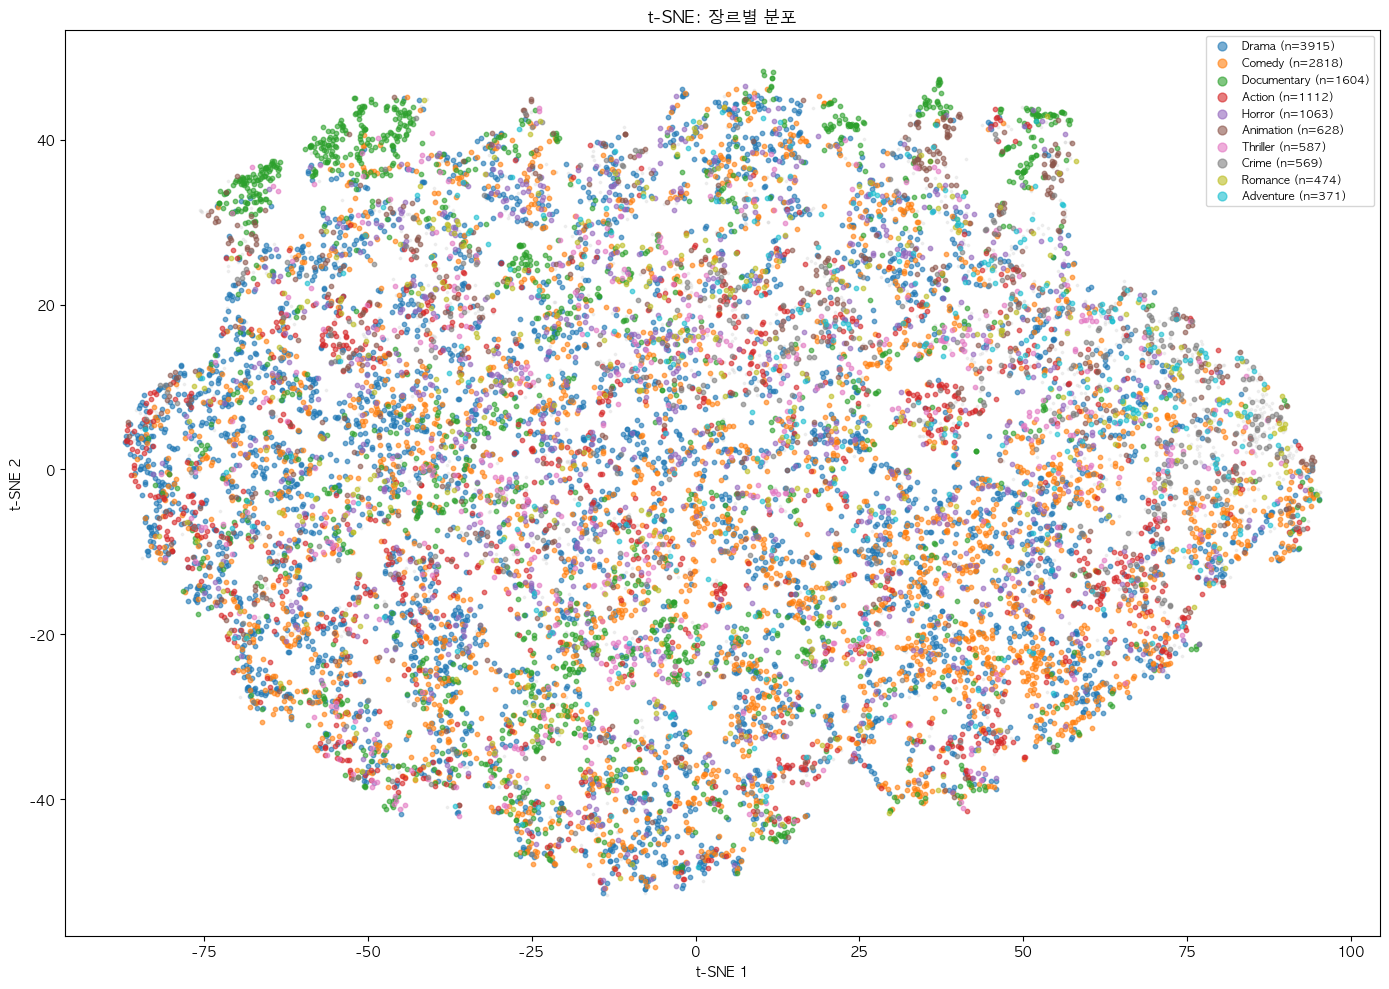

In [56]:
# 장르별 전체 시각화
plot_tsne_by_group(df_sample, 'genre_1', 't-SNE: 장르별 분포', top_k=10)

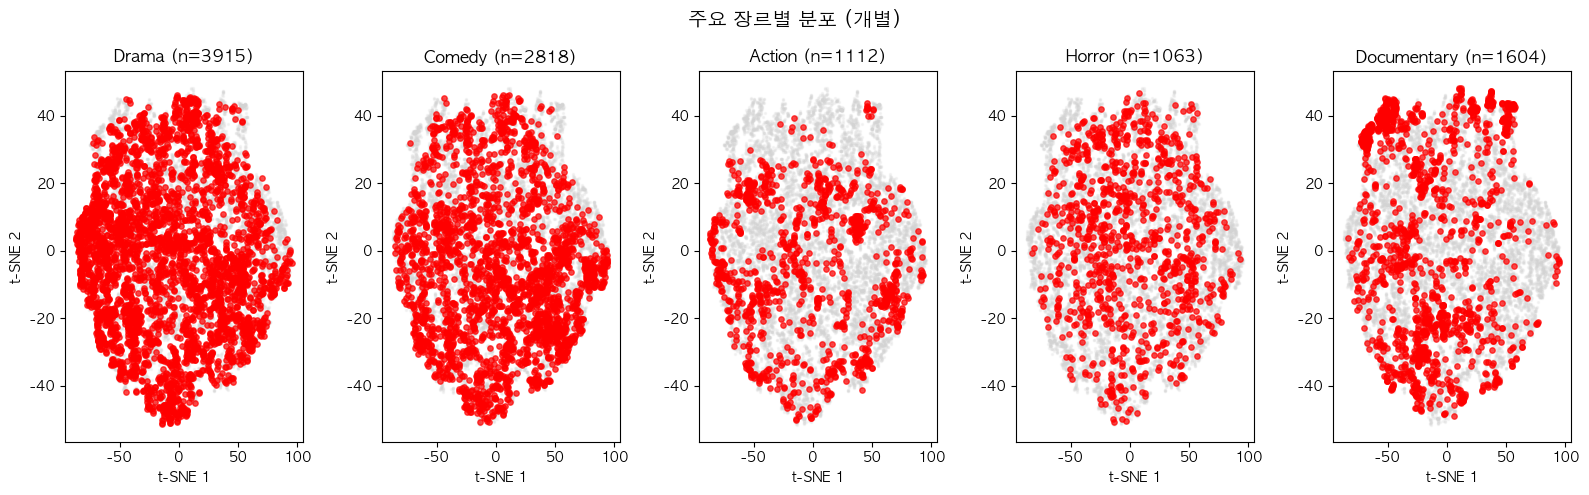

In [57]:
# 개별 장르 하이라이트 (주요 장르)
main_genres = ['Drama', 'Comedy', 'Action', 'Horror', 'Documentary']
plot_tsne_single_group(df_sample, 'genre_1', main_genres, '주요 장르별 분포 (개별)')

/var/folders/_1/_b2j1k9j665dmn902xbrr8h40000gn/T/ipykernel_3290/2177974382.py:88: UserWarning: Glyph 233 (\N{LATIN SMALL LETTER E WITH ACUTE}) missing from font(s) AppleGothic.
  plt.tight_layout()
/var/folders/_1/_b2j1k9j665dmn902xbrr8h40000gn/T/ipykernel_3290/2177974382.py:88: UserWarning: Glyph 232 (\N{LATIN SMALL LETTER E WITH GRAVE}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/jisoo/projects/thesis/carte_test/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 233 (\N{LATIN SMALL LETTER E WITH ACUTE}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jisoo/projects/thesis/carte_test/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 232 (\N{LATIN SMALL LETTER E WITH GRAVE}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


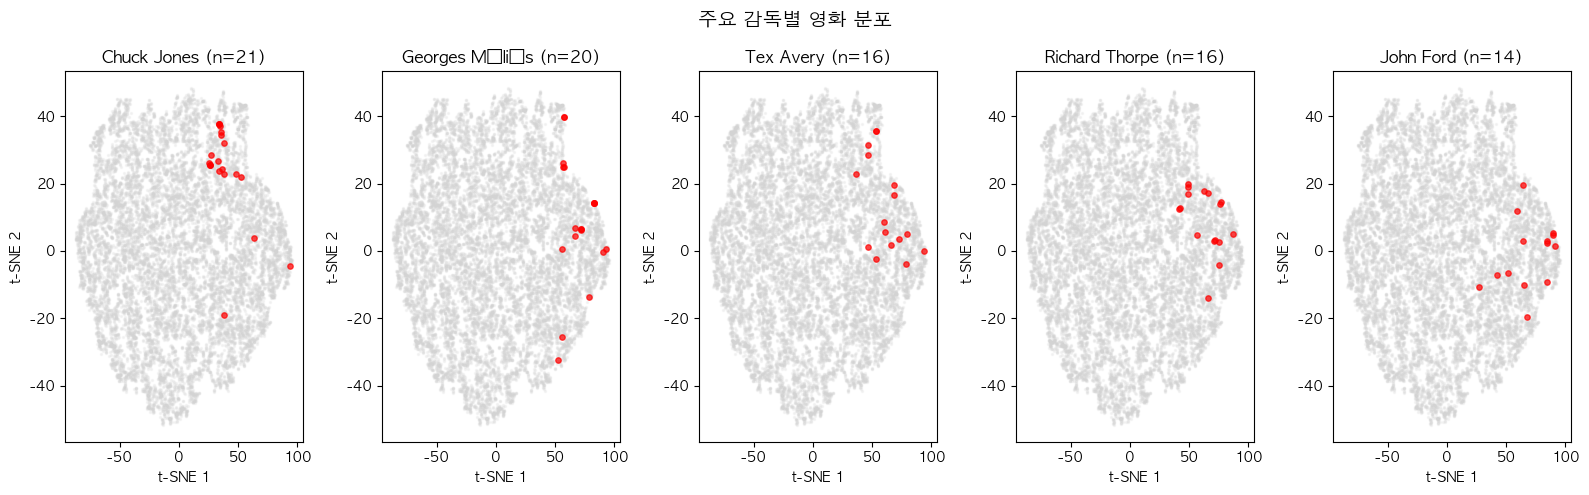

In [58]:
# 유명 감독별 시각화
if 'director_1' in df_sample.columns:
    # 샘플 내 빈도 높은 감독
    director_counts = df_sample['director_1'].value_counts()
    top_directors = director_counts[director_counts >= 5].head(10).index.tolist()
    
    if len(top_directors) >= 3:
        plot_tsne_single_group(
            df_sample, 'director_1', top_directors[:5],
            '주요 감독별 영화 분포'
        )

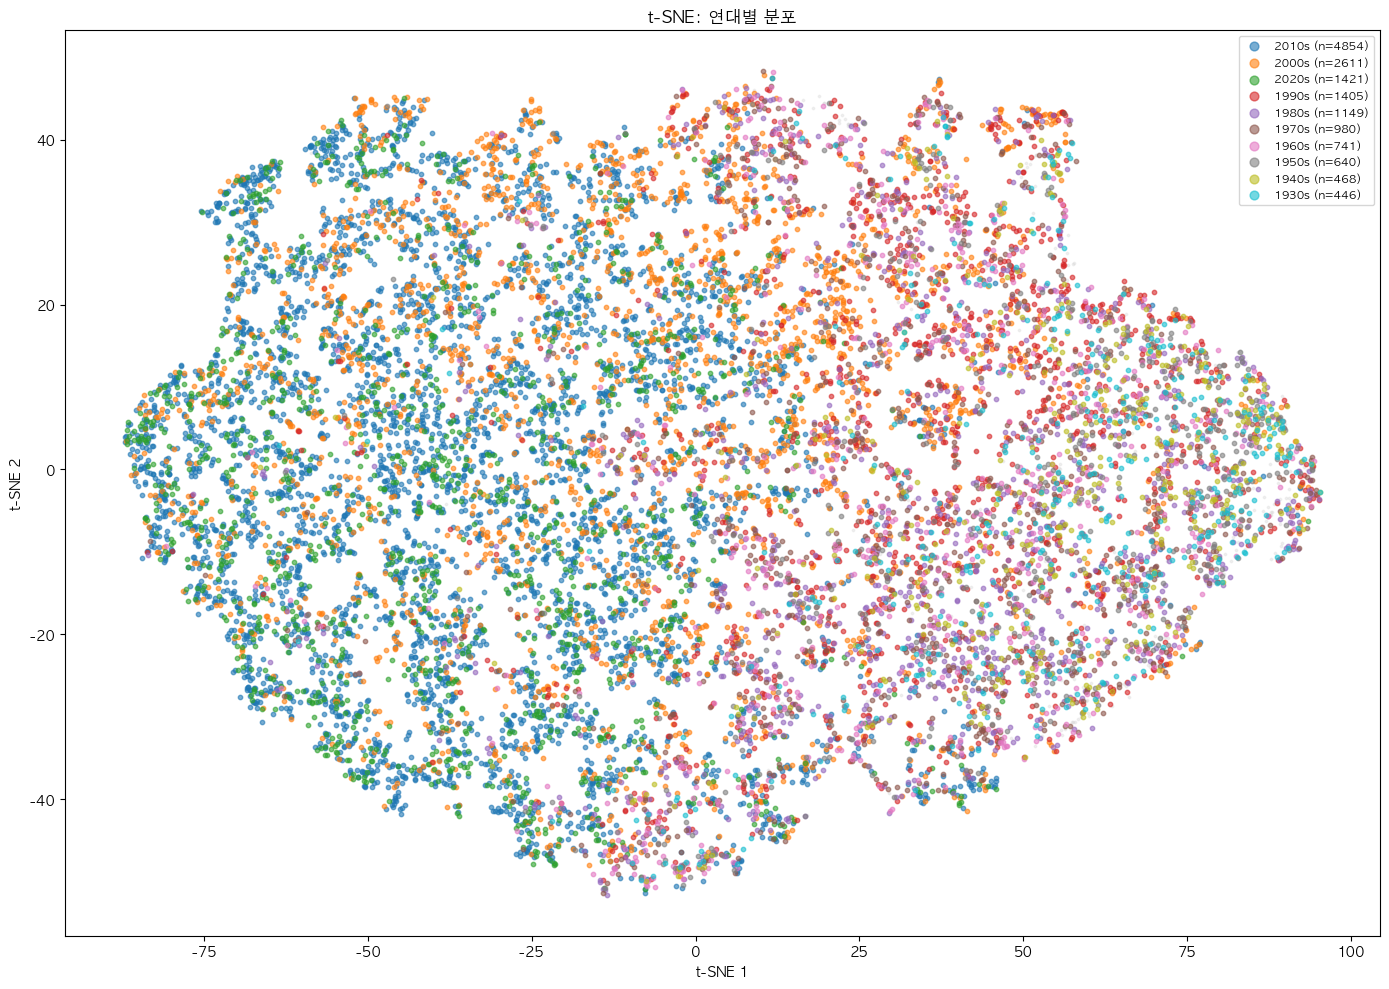

In [59]:
# 연대별 시각화
if 'decade' in df_sample.columns:
    plot_tsne_by_group(df_sample, 'decade', 't-SNE: 연대별 분포', top_k=10)

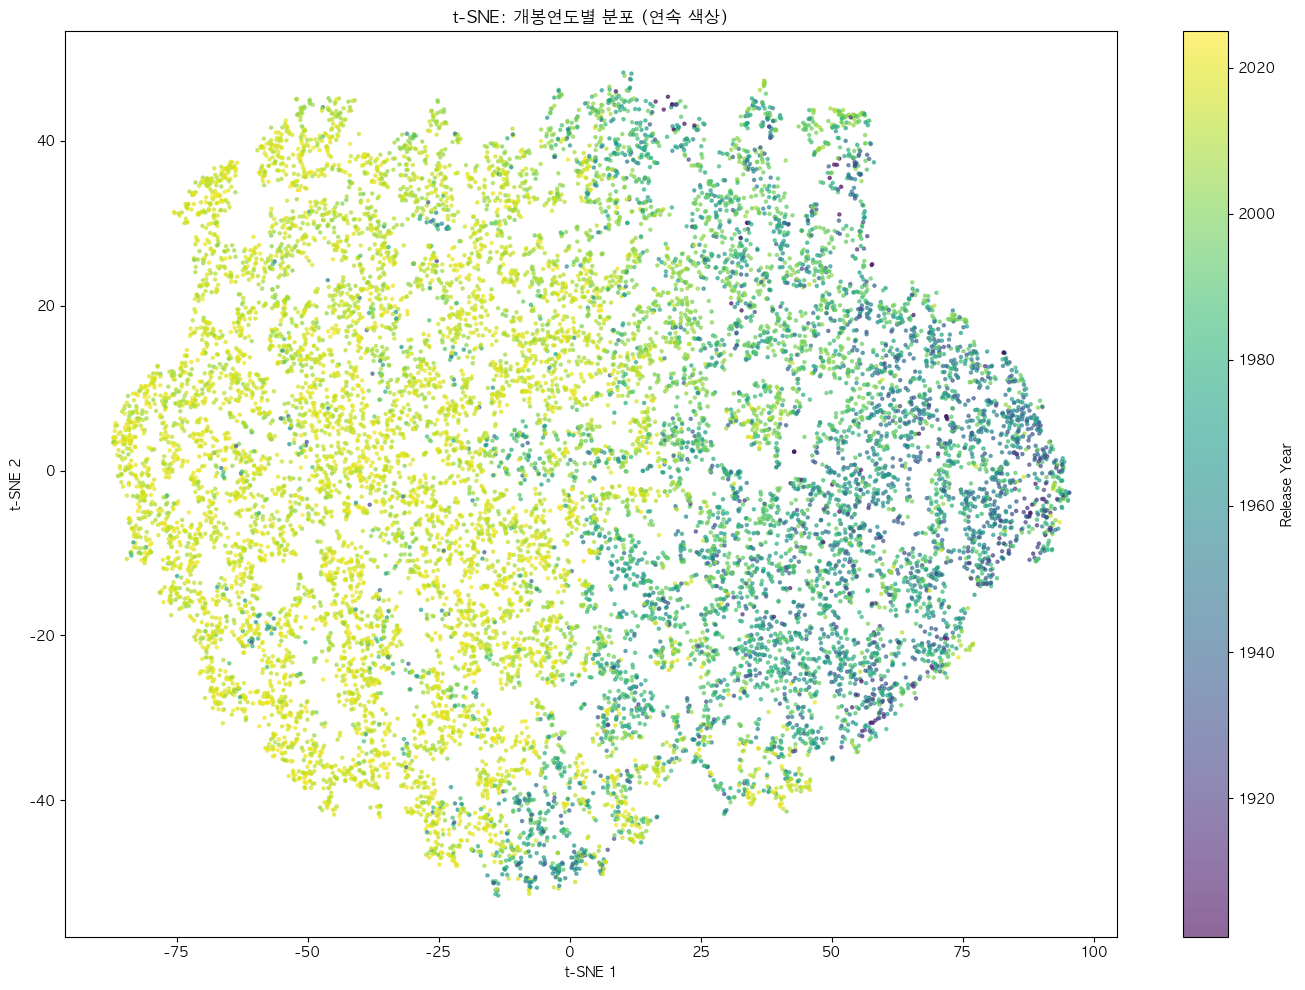

In [60]:
# 연도별 연속 색상
if 'release_year' in df_sample.columns:
    fig, ax = plt.subplots(figsize=(14, 10))
    
    years = df_sample['release_year'].fillna(0).astype(int).values
    valid_year_mask = years > 1900
    
    scatter = ax.scatter(
        df_sample.loc[valid_year_mask, 'tsne_x'],
        df_sample.loc[valid_year_mask, 'tsne_y'],
        c=years[valid_year_mask], cmap='viridis', s=5, alpha=0.6
    )
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Release Year')
    
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_title('t-SNE: 개봉연도별 분포 (연속 색상)')
    plt.tight_layout()
    plt.show()

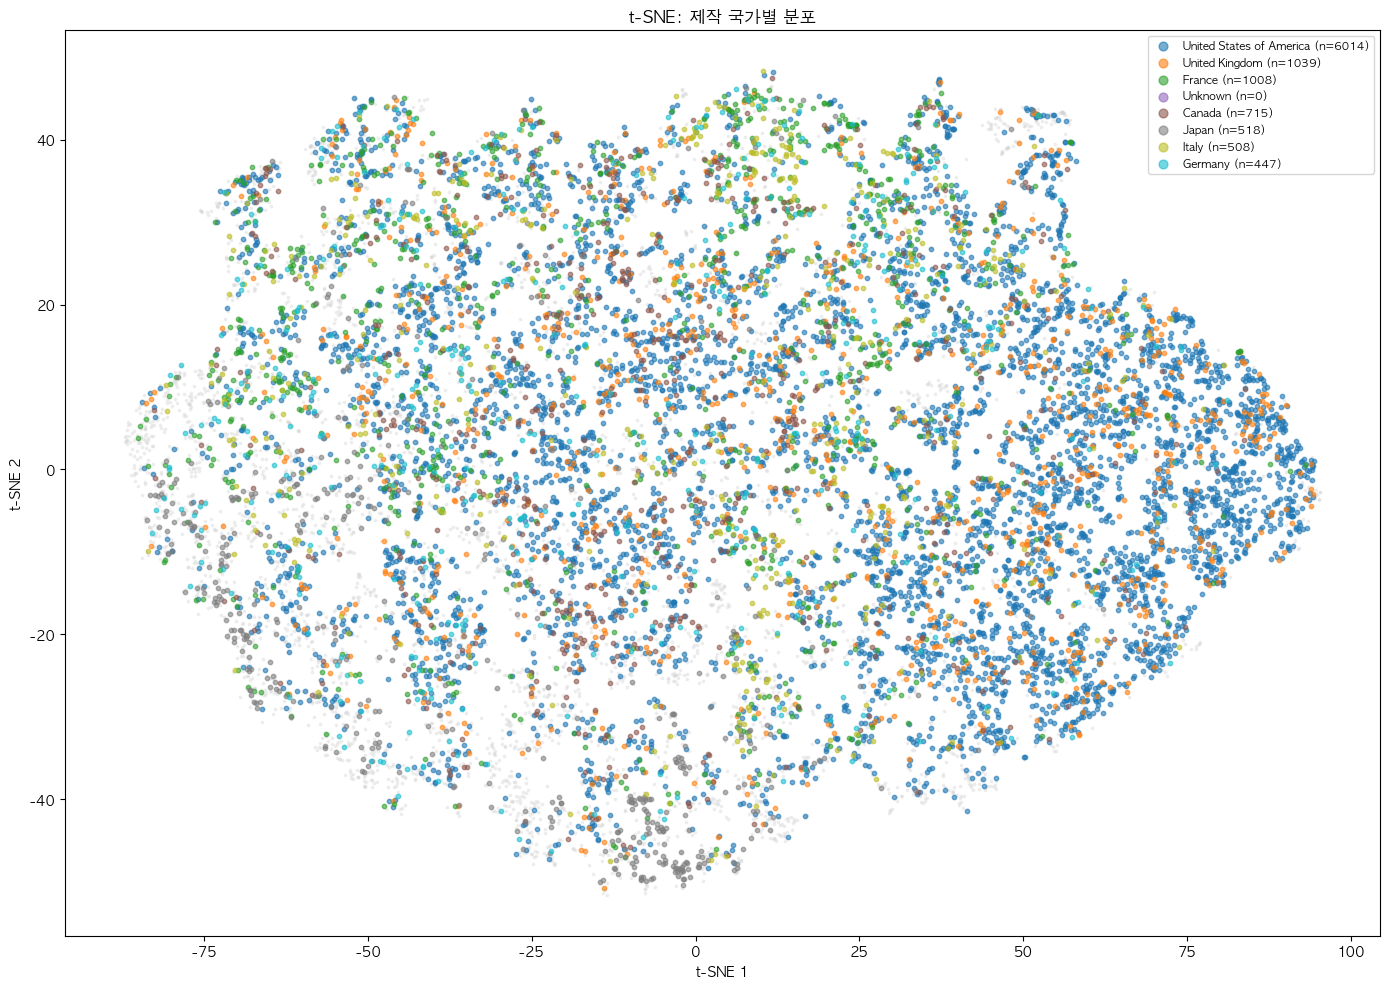

In [61]:
# 제작 국가별 시각화
if 'produced_in_country_1' in df_sample.columns:
    plot_tsne_by_group(
        df_sample, 'produced_in_country_1', 
        't-SNE: 제작 국가별 분포', top_k=8
    )

---
## 6. 유사 영화 분석 (전체 피처 비교)

유사도가 높은 영화들의 모든 피처를 비교하여 왜 유사하게 나왔는지 추적합니다.

In [62]:
def find_similar_movies_detailed(query_title: str, top_k: int = 10, 
                                  show_features: bool = True):
    """
    제목으로 영화를 찾고, 가장 유사한 영화들의 전체 피처를 비교합니다.
    
    Args:
        query_title: 검색할 영화 제목 (부분 일치)
        top_k: 상위 k개 유사 영화
        show_features: True면 전체 피처 테이블 출력
    
    Returns:
        DataFrame: 유사 영화 + 피처 비교 테이블
    """
    title_col = 'original_title' if 'original_title' in df.columns else 'title'
    
    # 제목 검색
    mask = df[title_col].str.contains(query_title, case=False, na=False)
    matches = df[mask]
    
    if len(matches) == 0:
        print(f"No movie found matching: {query_title}")
        return None
    
    # 첫 번째 매칭 사용
    query_idx = matches.index[0]
    query_movie = df.loc[query_idx]
    query_emb = emb_normalized[query_idx].reshape(1, -1)
    
    print("=" * 80)
    print(f"Query: {query_movie[title_col]} ({query_movie.get('release_year', 'N/A')})")
    print("=" * 80)
    
    # 쿼리 영화 피처 출력
    print("\n[Query Movie Features]")
    for col in FEATURE_COLS:
        val = query_movie.get(col, 'N/A')
        if pd.notna(val) and val != '':
            # 긴 텍스트는 자르기
            val_str = str(val)
            if len(val_str) > 80:
                val_str = val_str[:80] + '...'
            print(f"  {col:25s}: {val_str}")
    
    # 코사인 유사도 계산
    similarities = (emb_normalized @ query_emb.T).flatten()
    
    # 자기 자신 제외하고 정렬
    similarities[query_idx] = -1
    top_indices = np.argsort(similarities)[::-1][:top_k]
    
    print(f"\n\nTop {top_k} Similar Movies:")
    print("-" * 80)
    
    # 결과 수집
    results = []
    
    for rank, idx in enumerate(top_indices, 1):
        movie = df.iloc[idx]
        sim = similarities[idx]
        
        result = {
            'rank': rank,
            'similarity': sim,
        }
        
        # 피처 수집
        for col in FEATURE_COLS:
            result[col] = movie.get(col, None)
        
        # 쿼리와 일치하는 피처 표시
        matching_features = []
        for col in FEATURE_COLS:
            q_val = query_movie.get(col)
            m_val = movie.get(col)
            if pd.notna(q_val) and pd.notna(m_val) and str(q_val) == str(m_val):
                if col not in ['tagline', 'overview']:  # 긴 텍스트 제외
                    matching_features.append(col)
        
        result['matching_features'] = ', '.join(matching_features) if matching_features else 'None'
        results.append(result)
        
        # 출력
        title = movie.get(title_col, 'Unknown')
        year = movie.get('release_year', 'N/A')
        print(f"\n[{rank}] Similarity: {sim:.4f}")
        print(f"    Title: {title} ({year})")
        print(f"    Matching Features: {result['matching_features']}")
    
    # 전체 피처 비교 테이블
    if show_features:
        print("\n\n" + "=" * 80)
        print("전체 피처 비교 테이블")
        print("=" * 80)
        
        # Query movie를 첫 번째 행으로
        query_result = {
            'rank': 0,
            'similarity': 1.0,
        }
        for col in FEATURE_COLS:
            query_result[col] = query_movie.get(col, None)
        query_result['matching_features'] = 'QUERY'
        
        all_results = [query_result] + results
        df_results = pd.DataFrame(all_results)
        
        # 주요 컬럼만 선택
        display_cols = ['rank', 'similarity', 'original_title', 'release_year',
                       'genre_1', 'genre_2', 'director_1', 'actor_1', 'actor_2',
                       'produced_in_country_1', 'matching_features']
        display_cols = [c for c in display_cols if c in df_results.columns]
        
        # HTML로 표시 (주피터 환경)
        try:
            display(df_results[display_cols].style.format({'similarity': '{:.4f}'}))
        except:
            print(df_results[display_cols].to_string())
    
    return pd.DataFrame(results)

In [63]:
# 테스트 1: Toy Story
find_similar_movies_detailed("Toy Story", top_k=10)

Query: Toy Story (1995)

[Query Movie Features]
  original_title           : Toy Story
  release_year             : 1995
  tagline                  : Hang on for the comedy that goes to infinity and beyond!
  overview                 : Led by Woody, Andy's toys live happily in his room until Andy's birthday brings ...
  genre_1                  : Family
  genre_2                  : Comedy
  genre_3                  : Animation
  director_1               : John Lasseter
  writer_1                 : Joss Whedon
  actor_1                  : Tom Hanks
  actor_2                  : Tim Allen
  actor_3                  : Don Rickles
  produced_by_company_1    : Pixar
  produced_in_country_1    : United States of America
  spoken_language_1        : English


Top 10 Similar Movies:
--------------------------------------------------------------------------------

[1] Similarity: 0.9996
    Title: The Odd Job (1978)
    Matching Features: spoken_language_1

[2] Similarity: 0.9996
    Title: Mast

rank  similarity           original_title  release_year  \
0     1    0.999636              The Odd Job          1978   
1     2    0.999573  Masters of the Universe          1987   
2     3    0.999551                 Red Heat          1985   
3     4    0.999305             The Neighbor          1993   
4     5    0.999264                     2010          1984   
5     6    0.999248       Scandal at Scourie          1953   
6     7    0.999231                  Hi-Life          1998   
7     8    0.999229             Golden Years          1991   
8     9    0.999218    Vermont Is for Lovers          1993   
9    10    0.999218       Up in Central Park          1948   

                                             tagline  \
0                                               None   
1  A battle fought in the stars...now comes to Ea...   
2  Explore the naked passions in this hot-house o...   
3                        He's closer than you think.   
4  In the very near future, a small group of Amer...   
5  Together Again In A NEW And Wonderful Motion P...   
6  A romantic comedy for the romantically challen...   
7                                               None   
8                                               None   
9                                               None   

                                            overview          genre_1  \
0  Arthur Harris is a happily married man who ret...           Comedy   
1  When the evil Skeletor finds a mysterious powe...           Action   
2  East Germans abduct a U.S. coed (Linda Blair) ...         Thriller   
3  A young couple, Mary and John, awaiting a baby...         Thriller   
4  While planet Earth poises on the brink of nucl...         Thriller   
5  After their orphanage burns down, a group of c...            Drama   
6  Jimmy needs $900 to clear a gambling debt but ...           Comedy   
7  When an explosion at a top-secret government l...  Science Fiction   
8  Vermont is for Lovers is an independently prod...           Comedy   
9  A newspaper reporter and the daughter of an im...            Music   

           genre_2          genre_3         director_1          writer_1  \
0             None             None        Peter Medak    Graham Chapman   
1          Fantasy  Science Fiction       Gary Goddard       David Odell   
2             None             None   Robert Collector  Robert Collector   
3           Horror             None     Rodney Gibbons       Kurt Wimmer   
4  Science Fiction             None        Peter Hyams       Peter Hyams   
5             None             None     Jean Negulesco      Karl Tunberg   
6          Romance             None       Roger Hedden      Roger Hedden   
7         Thriller         TV Movie    Michael Gornick    Josef Anderson   
8      Documentary             None       John O'Brien      John O'Brien   
9             None             None  William A. Seiter      Karl Tunberg   

            actor_1           actor_2         actor_3  \
0    Graham Chapman       David Jason     Diana Quick   
1    Dolph Lundgren    Frank Langella      Meg Foster   
2       Linda Blair    Sylvia Kristel        Sue Kiel   
3       Rod Steiger   Linda Kozlowski         Ron Lea   
4      Roy Scheider      John Lithgow    Helen Mirren   
5      Greer Garson    Walter Pidgeon  Donna Corcoran   
6       Eric Stoltz      Daryl Hannah  Campbell Scott   
7  Keith Szarabajka  Felicity Huffman       Ed Lauter   
8     George Thrush        Marya Cohn     Ann O'Brien   
9     Deanna Durbin       Dick Haymes   Vincent Price   

              produced_by_company_1 produced_by_company_2  \
0                    Charisma Films                  None   
1                     Pressman Film      The Cannon Group   
2                          TAT Film           Aida United   
3                          Westwind         Allegro Films   
4               Metro-Goldwyn-Mayer                  None   
5               Metro-Goldwyn-Mayer                  None   
6      

In [64]:
# 테스트 2: The Godfather
find_similar_movies_detailed("The Godfather", top_k=10)

Query: The Godfather (1972)

[Query Movie Features]
  original_title           : The Godfather
  release_year             : 1972
  tagline                  : An offer you can't refuse.
  overview                 : Spanning the years 1945 to 1955, a chronicle of the fictional Italian-American C...
  genre_1                  : Drama
  genre_2                  : Crime
  director_1               : Francis Ford Coppola
  writer_1                 : Mario Puzo
  actor_1                  : Marlon Brando
  actor_2                  : Al Pacino
  actor_3                  : James Caan
  produced_by_company_1    : Paramount Pictures
  produced_by_company_2    : Alfran Productions
  produced_in_country_1    : United States of America
  spoken_language_1        : English


Top 10 Similar Movies:
--------------------------------------------------------------------------------

[1] Similarity: 0.9995
    Title: The Ugly American (1963)
    Matching Features: actor_1, produced_in_country_1, spoken_langu

rank  similarity              original_title  release_year  \
0     1    0.999524           The Ugly American          1963   
1     2    0.999510           Wedding Rehearsal          1932   
2     3    0.999509  The Greatest Show on Earth          1952   
3     4    0.999457              The Stone Tape          1972   
4     5    0.999333        When the Whales Came          1989   
5     6    0.999329                    Captives          1994   
6     7    0.999305       Murder in Mississippi          1990   
7     8    0.999304                  Nightbreed          1990   
8     9    0.999259                    Delta Pi          1984   
9    10    0.999253               Blood Sabbath          1972   

                                             tagline  \
0          The most explosive adventure of our time!   
1                                               None   
2  The Heartbeat Story of Circus People, Filmed w...   
3                                               None   
4    A story so enchanting you'll wish it were real.   
5                      How far will you go for love?   
6                                               None   
7                    A new reason to fear the night.   
8                        These girls go all the way!   
9  They were evil. They were sadistic... And drop...   

                                            overview   genre_1   genre_2  \
0  An intelligent, articulate scholar, Harrison M...  Thriller     Drama   
1  The grandmother of a British nobleman, relucta...    Comedy     Drama   
2  To ensure a full profitable season, circus man...     Drama   Romance   
3  A research team from an electronics company mo...    Horror  TV Movie   
4  A pair of children befriend an eccentric old m...     Drama      None   
5  A beautiful young dentist working in a tough B...     Drama  Thriller   
6  In 1964, members of the Ku Klux Klan murdered ...  TV Movie     Drama   
7  A troubled young man is drawn to a mythical pl...    Horror   Fantasy   
8  A sorority house mother enters her girls in a ...    Comedy      None   
9  A young man named David unknowingly ventures i...    Horror   Fantasy   

   genre_3        director_1          writer_1         actor_1  \
0     None    George Englund     Stewart Stern   Marlon Brando   
1     None   Alexander Korda      Helen Gardom    Roland Young   
2     None  Cecil B. DeMille  Fredric M. Frank    Betty Hutton   
3  Mystery       Peter Sasdy      Nigel Kneale  Michael Bryant   
4     None        Clive Rees  Michael Morpurgo   Paul Scofield   
5  Mystery       Angela Pope       Frank Deasy    Julia Ormond   
6     None       Roger Young    Stanley Weiser       Tom Hulce   
7   Action      Clive Barker      Clive Barker   Craig Sheffer   
8     None      Kevin Brodie      Kevin Brodie     Ruth Gordon   
9  Romance    Brianne Murphy  William A. Bairn   Anthony Geary   

            actor_2           actor_3             produced_by_company_1  \
0        Eiji Okada     Sandra Church  Universal International Pictures   
1  George Grossmith        John Loder          London Films Productions   
2      Cornel Wilde   Charlton Heston                Paramount Pictures   
3        Jane Asher  Iain Cuthbertson                               BBC   
4   David Threlfall      Helen Mirren        American Continental Corp.   
5          Tim Roth      Colin Salmon                               BBC   
6     Jennifer Grey   Blair Underwood                              None   
7        Anne Bobby  David Cronenberg                    Seraphim Films   
8    Laura Branigan     Joanna Dierck                    Pegasus Cinema   
9     Susan Damante        Sam Gilman           Barbet Film Productions   

        produced_by_company_2     produced_in_country_1 spoken_language_1  \
0                        None  United States of America           English   
1                        None            United Kingdom           English   
2                        None  United States of A

In [65]:
# 테스트 3: Inception
find_similar_movies_detailed("Inception", top_k=10)

Query: Inception (2010)

[Query Movie Features]
  original_title           : Inception
  release_year             : 2010
  tagline                  : Your mind is the scene of the crime.
  overview                 : Cobb, a skilled thief who commits corporate espionage by infiltrating the subcon...
  genre_1                  : Action
  genre_2                  : Science Fiction
  genre_3                  : Adventure
  director_1               : Christopher Nolan
  writer_1                 : Christopher Nolan
  actor_1                  : Leonardo DiCaprio
  actor_2                  : Joseph Gordon-Levitt
  actor_3                  : Ken Watanabe
  produced_by_company_1    : Legendary Pictures
  produced_by_company_2    : Syncopy
  produced_in_country_1    : United Kingdom
  spoken_language_1        : English


Top 10 Similar Movies:
--------------------------------------------------------------------------------

[1] Similarity: 0.9997
    Title: Varg Veum - Kvinnen i kjøleskapet (2008)

rank  similarity                     original_title  release_year  \
0     1    0.999659  Varg Veum - Kvinnen i kjøleskapet          2008   
1     2    0.999642                           Kick-Ass          2010   
2     3    0.999599          Thor - Hammer of the Gods          2009   
3     4    0.999582               Red: Werewolf Hunter          2010   
4     5    0.999581                               Lamb          2015   
5     6    0.999496             My Mom's New Boyfriend          2008   
6     7    0.999421           The Pit and the Pendulum          2009   
7     8    0.999412                     Circle of Fury          2010   
8     9    0.999410                   Io, Don Giovanni          2009   
9    10    0.999409            Не будите спящую собаку          1991   

                                             tagline  \
0                                               None   
1                                 Shut up. Kick-ass.   
2                                               None   
3                                               None   
4                       Innocence walks a fine line.   
5  His mom is dating his suspect. Let the surveil...   
6  Edgar Allan Poe's riveting tale of horror grip...   
7              Back in the ring is the only way out!   
8                                               None   
9                                               None   

                                            overview  genre_1    genre_2  \
0  An international oil drilling company hires pr...    Crime   Thriller   
1  Dave Lizewski is an unnoticed high school stud...   Action      Crime   
2  Thor, along with his friends, travel to a myst...   Action  Adventure   
3  The modern-day descendant of Little Red Riding...  Fantasy     Horror   
4  Lamb, based on the novel by Bonnie Nadzam, tra...    Drama       None   
5  After several years away, FBI agent Henry Dura...   Action     Comedy   
6  Seven students answer an advertisement to part...  Fantasy     Horror   
7  Back from Iraq, Johnny Brown discovers that a ...   Action  Adventure   
8  A drama based on the life of 18th century Ital...    Drama    Romance   
9  After coming out of jail a sneak thief "Chibis...    Crime     Comedy   

    genre_3           director_1            writer_1               actor_1  \
0      None        Alexander Eik        Lars Skorpen      Trond Espen Seim   
1      None       Matthew Vaughn        Jane Goldman  Aaron Taylor-Johnson   
2     Drama    Teodore Chapkunov       Rafael Jordan      Zachery Ty Bryan   
3    Action       Sheldon Wilson                None           Felicia Day   
4      None       Ross Partridge      Ross Partridge         Oona Laurence   
5     Crime         George Gallo        George Gallo              Meg Ryan   
6  Thriller       David DeCoteau        Simon Savory          Lorielle New   
7      None         John Bacchus        John Bacchus          Randy Spence   
8      None         Carlos Saura  Alessandro Vallini      Lorenzo Balducci   
9      None  Anatoliy Bobrovskiy  Vladimir Kuznetsov         Viktor Pavlov   

              actor_2            actor_3  \
0       Bjørn Floberg  Endre Hellestveit   
1  Chloë Grace Moretz       Nicolas Cage   
2          Mac Brandt       Daz Crawford   
3         Kavan Smith   Stephen McHattie   
4      Ross Partridge       Jess Weixler   
5    Antonio Banderas        Colin Hanks   
6      Stephen Hansen       Bart Voitila   
7     Adonis Williams     Christina Rose   
8      Lino Guanciale  Emilia Verginelli   
9     Aleksei Zharkov     Vladimir Etush   

                   produced_by_company_1     produced_by_company_2  \
0                               SF Norge                 Miso Film   
1                                   Marv      Plan B Entertainment   
2                                   Syfy  NBC Universal Television   
3         Chesler/Perlmutter Productions                      None   
4                      Silent Helicopter            The Shot C

In [66]:
# 테스트 4: The Dark Knight
find_similar_movies_detailed("The Dark Knight", top_k=10)

Query: The Dark Knight (2008)

[Query Movie Features]
  original_title           : The Dark Knight
  release_year             : 2008
  tagline                  : Welcome to a world without rules.
  overview                 : Batman raises the stakes in his war on crime. With the help of Lt. Jim Gordon an...
  genre_1                  : Drama
  genre_2                  : Action
  genre_3                  : Crime
  director_1               : Christopher Nolan
  writer_1                 : Christopher Nolan
  actor_1                  : Christian Bale
  actor_2                  : Heath Ledger
  actor_3                  : Aaron Eckhart
  produced_by_company_1    : Warner Bros. Pictures
  produced_by_company_2    : Legendary Pictures
  produced_in_country_1    : United Kingdom
  spoken_language_1        : English


Top 10 Similar Movies:
--------------------------------------------------------------------------------

[1] Similarity: 0.9998
    Title: Push (2009)
    Matching Features: genre_

rank  similarity                        original_title  release_year  \
0     1    0.999751                                  Push          2009   
1     2    0.999656                             The Dread          2007   
2     3    0.999623   The Most Wonderful Time of the Year          2008   
3     4    0.999593                       Nightmare Alley          2021   
4     5    0.999581                           Ghost Rider          2007   
5     6    0.999575                   Water for Elephants          2011   
6     7    0.999572                         The Last Kiss          2006   
7     8    0.999570  Thomas & Friends: Day of the Diesels          2011   
8     9    0.999568                               Tangled          2010   
9    10    0.999551                              Maladies          2012   

                                             tagline  \
0                    One push can change everything.   
1                                  Death lies within   
2                                               None   
3                                      Man or beast.   
4  Long ago he made a deal to save someone he loved.   
5        Life is the most spectacular show on earth.   
6                 We all make choices. What's yours?   
7                                               None   
8           They're taking adventure to new lengths.   
9                                               None   

                                            overview          genre_1  \
0  After his father, an assassin, is brutally mur...  Science Fiction   
1  A young woman becomes filled with a horrible d...           Horror   
2  Five-time Emmy nominee and Golden Globe winner...         TV Movie   
3  An ambitious carnival man with a talent for ma...            Crime   
4  In order to save his dying father, young stunt...         Thriller   
5  In this captivating Depression-era melodrama, ...            Drama   
6  Michael has a great job, has his 4 best friend...           Comedy   
7  The Steamies and the Diesels face off in this ...           Family   
8  Feisty teenager Rapunzel, who has long and mag...        Animation   
9  A former soap star appears to have a narrator ...            Drama   

     genre_2    genre_3           director_1             writer_1  \
0     Action  Adventure        Paul McGuigan         David Bourla   
1   Thriller       None       Michael Spence         Casey Conlon   
2      Drama    Romance     Michael M. Scott         Bruce Graham   
3      Drama   Thriller   Guillermo del Toro           Kim Morgan   
4     Action    Fantasy  Mark Steven Johnson  Mark Steven Johnson   
5    Romance       None     Francis Lawrence  Richard LaGravenese   
6      Drama    Romance         Tony Goldwyn     Gabriele Muccino   
7  Animation       None         Greg Tiernan        Sharon Miller   
8     Family  Adventure         Byron Howard         Dan Fogelman   
9       None       None               Carter               Carter   

            actor_1            actor_2             actor_3  \
0       Chris Evans     Dakota Fanning       Camilla Belle   
1    Sally Pressman    Ellen Sandweiss  Ryan Patrick Welsh   
2      Brooke Burns      Henry Winkler     Warren Christie   
3    Bradley Cooper     Cate Blanchett       Toni Collette   
4      Nicolas Cage         Eva Mendes         Sam Elliott   
5  Robert Pattinson  Reese Witherspoon     Christoph Waltz   
6        Zach Braff    Jacinda Barrett       Casey Affleck   
7   Michael Angelis       Rupert Degas           Ben Small   
8       Mandy Moore       Zachary Levi        Donna Murphy   
9      James Franco   Catherine Keener      Fallon Goodson   

           produced_by_company_1    produced_by_company_2  \
0           Summit Entertainment         Icon Productions   
1                   Westar Films                     None   
2                 KZ Productions  Dan Wigutow Productions   
3           Searchlight Pictures          Double Dare You   
4       

---
## 6.5 시리즈 영화 유사도 검증 (반지의 제왕 & 호빗)

같은 세계관/감독의 시리즈 영화들이 높은 유사도를 보이는지 검증합니다.
- **반지의 제왕 3부작** (2001-2003, 피터 잭슨)
- **호빗 3부작** (2012-2014, 피터 잭슨)

기대: 시리즈 내 영화들은 매우 높은 유사도, 두 시리즈 간에도 높은 유사도를 보여야 함

In [67]:
def find_movie_idx(title_query: str):
    """영화 제목으로 인덱스를 찾습니다."""
    title_col = 'original_title' if 'original_title' in df.columns else 'title'
    mask = df[title_col].str.contains(title_query, case=False, na=False)
    if mask.sum() == 0:
        return None, None
    idx = df[mask].index[0]
    return idx, df.loc[idx, title_col]


def compute_series_similarity_matrix(movie_titles: list):
    """
    시리즈 영화들 간의 유사도 행렬을 계산합니다.
    
    Args:
        movie_titles: 검색할 영화 제목 리스트 (부분 일치)
    
    Returns:
        similarity_matrix, found_titles, found_indices
    """
    found_indices = []
    found_titles = []
    
    for title in movie_titles:
        idx, full_title = find_movie_idx(title)
        if idx is not None:
            found_indices.append(idx)
            found_titles.append(full_title)
        else:
            print(f"⚠️ Not found: {title}")
    
    if len(found_indices) < 2:
        print("Not enough movies found!")
        return None, None, None
    
    # 유사도 행렬 계산
    n = len(found_indices)
    sim_matrix = np.zeros((n, n))
    
    for i, idx_i in enumerate(found_indices):
        for j, idx_j in enumerate(found_indices):
            sim_matrix[i, j] = np.dot(emb_normalized[idx_i], emb_normalized[idx_j])
    
    return sim_matrix, found_titles, found_indices


def visualize_series_similarity(sim_matrix: np.ndarray, titles: list, 
                                 series_labels: list = None, title: str = ""):
    """
    시리즈 유사도 행렬을 히트맵으로 시각화합니다.
    
    Args:
        sim_matrix: 유사도 행렬
        titles: 영화 제목 리스트
        series_labels: 각 영화의 시리즈 레이블 (색상 구분용)
        title: 플롯 제목
    """
    n = len(titles)
    
    # 제목 줄이기
    short_titles = []
    for t in titles:
        if "Lord of the Rings" in t:
            if "Fellowship" in t:
                short_titles.append("LOTR 1: Fellowship")
            elif "Two Towers" in t:
                short_titles.append("LOTR 2: Two Towers")
            elif "Return" in t:
                short_titles.append("LOTR 3: Return")
            else:
                short_titles.append(t[:25])
        elif "Hobbit" in t:
            if "Unexpected" in t:
                short_titles.append("Hobbit 1: Unexpected")
            elif "Desolation" in t:
                short_titles.append("Hobbit 2: Desolation")
            elif "Battle" in t or "Five Armies" in t:
                short_titles.append("Hobbit 3: Battle")
            else:
                short_titles.append(t[:25])
        else:
            short_titles.append(t[:25])
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # 히트맵
    im = ax.imshow(sim_matrix, cmap='RdYlGn', vmin=0.9, vmax=1.0)
    
    # 축 설정
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(short_titles, rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(short_titles, fontsize=9)
    
    # 값 표시
    for i in range(n):
        for j in range(n):
            val = sim_matrix[i, j]
            color = 'white' if val < 0.95 else 'black'
            ax.text(j, i, f'{val:.4f}', ha='center', va='center', 
                   fontsize=8, color=color)
    
    # 시리즈 구분선
    if series_labels:
        # 시리즈 경계 찾기
        for i in range(1, n):
            if series_labels[i] != series_labels[i-1]:
                ax.axhline(i - 0.5, color='blue', linewidth=2)
                ax.axvline(i - 0.5, color='blue', linewidth=2)
    
    plt.colorbar(im, ax=ax, label='Cosine Similarity')
    ax.set_title(title, fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return short_titles

In [68]:
# 반지의 제왕 & 호빗 시리즈 정의
LOTR_SERIES = [
    "Lord of the Rings: The Fellowship",
    "Lord of the Rings: The Two Towers", 
    "Lord of the Rings: The Return of the King",
]

HOBBIT_SERIES = [
    "Hobbit: An Unexpected Journey",
    "Hobbit: The Desolation of Smaug",
    "Hobbit: The Battle of the Five Armies",
]

# 전체 Middle-earth 시리즈
MIDDLE_EARTH = LOTR_SERIES + HOBBIT_SERIES
SERIES_LABELS = ['LOTR'] * 3 + ['Hobbit'] * 3

# 유사도 행렬 계산
sim_matrix, found_titles, found_indices = compute_series_similarity_matrix(MIDDLE_EARTH)

if sim_matrix is not None:
    print(f"\n찾은 영화: {len(found_titles)}개")
    for i, title in enumerate(found_titles):
        print(f"  {i+1}. {title}")


찾은 영화: 6개
  1. The Lord of the Rings: The Fellowship of the Ring
  2. The Lord of the Rings: The Two Towers
  3. The Lord of the Rings: The Return of the King
  4. The Hobbit: An Unexpected Journey
  5. The Hobbit: The Desolation of Smaug
  6. The Hobbit: The Battle of the Five Armies


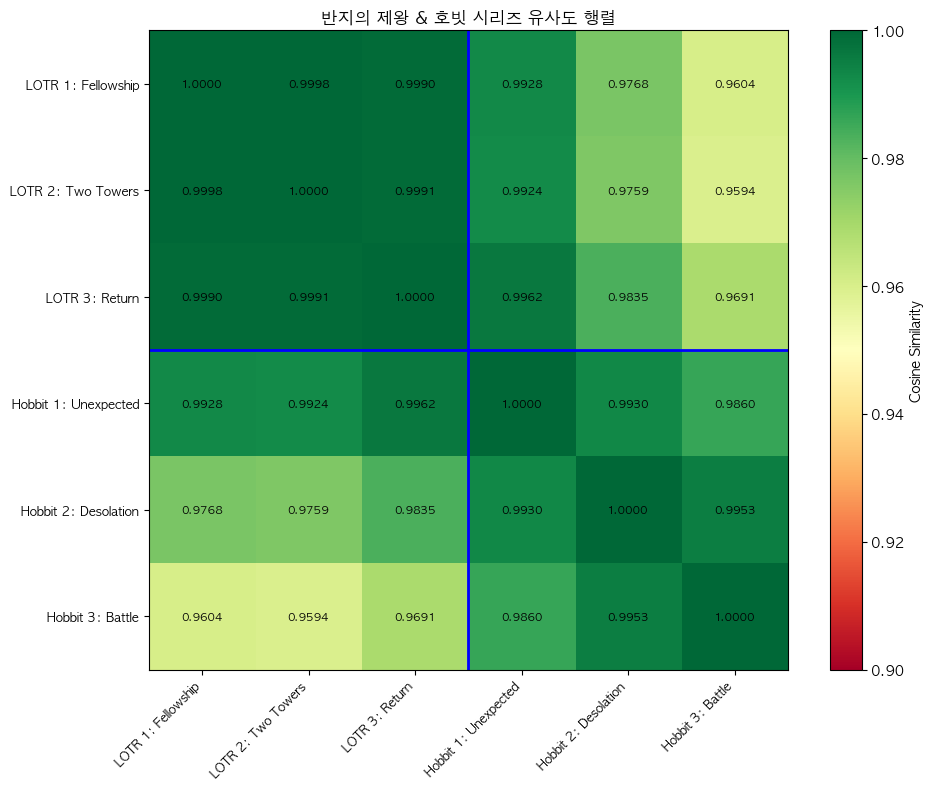

In [69]:
# 유사도 히트맵 시각화
if sim_matrix is not None:
    visualize_series_similarity(
        sim_matrix, found_titles, 
        series_labels=SERIES_LABELS,
        title="반지의 제왕 & 호빗 시리즈 유사도 행렬"
    )

In [70]:
# 시리즈 유사도 통계 분석
if sim_matrix is not None:
    print("=" * 60)
    print("시리즈 유사도 통계")
    print("=" * 60)
    
    n = len(found_titles)
    
    # 시리즈 내 유사도 (대각선 제외)
    lotr_sims = []
    hobbit_sims = []
    cross_sims = []
    
    for i in range(n):
        for j in range(i+1, n):
            sim = sim_matrix[i, j]
            
            # 둘 다 LOTR
            if SERIES_LABELS[i] == 'LOTR' and SERIES_LABELS[j] == 'LOTR':
                lotr_sims.append(sim)
            # 둘 다 Hobbit
            elif SERIES_LABELS[i] == 'Hobbit' and SERIES_LABELS[j] == 'Hobbit':
                hobbit_sims.append(sim)
            # 서로 다른 시리즈
            else:
                cross_sims.append(sim)
    
    print(f"\n[LOTR 시리즈 내 유사도]")
    print(f"  평균: {np.mean(lotr_sims):.4f}")
    print(f"  범위: [{np.min(lotr_sims):.4f}, {np.max(lotr_sims):.4f}]")
    
    print(f"\n[Hobbit 시리즈 내 유사도]")
    print(f"  평균: {np.mean(hobbit_sims):.4f}")
    print(f"  범위: [{np.min(hobbit_sims):.4f}, {np.max(hobbit_sims):.4f}]")
    
    print(f"\n[LOTR ↔ Hobbit 시리즈 간 유사도]")
    print(f"  평균: {np.mean(cross_sims):.4f}")
    print(f"  범위: [{np.min(cross_sims):.4f}, {np.max(cross_sims):.4f}]")
    
    # 전체 평균 랜덤 유사도와 비교
    all_series_sims = lotr_sims + hobbit_sims + cross_sims
    print(f"\n[비교]")
    print(f"  시리즈 전체 평균 유사도: {np.mean(all_series_sims):.4f}")
    print(f"  랜덤 페어 평균 유사도: {random_sims.mean():.4f}")
    print(f"  차이: {np.mean(all_series_sims) - random_sims.mean():.4f}")
    
    # 판정
    print(f"\n[판정]")
    if np.mean(all_series_sims) > random_sims.mean() + 0.01:
        print("  ✓ 시리즈 영화들이 랜덤 영화보다 유사도가 높음 (정상)")
    else:
        print("  ⚠️ 시리즈 영화들의 유사도가 랜덤과 비슷함 (문제 가능성)")

시리즈 유사도 통계

[LOTR 시리즈 내 유사도]
  평균: 0.9993
  범위: [0.9990, 0.9998]

[Hobbit 시리즈 내 유사도]
  평균: 0.9914
  범위: [0.9860, 0.9953]

[LOTR ↔ Hobbit 시리즈 간 유사도]
  평균: 0.9785
  범위: [0.9594, 0.9962]

[비교]
  시리즈 전체 평균 유사도: 0.9852
  랜덤 페어 평균 유사도: 0.9505
  차이: 0.0347

[판정]
  ✓ 시리즈 영화들이 랜덤 영화보다 유사도가 높음 (정상)


In [ ]:
# 시리즈 영화들의 피처 비교
if sim_matrix is not None and found_indices:
    print("=" * 60)
    print("시리즈 영화 피처 비교")
    print("=" * 60)
    
    # 비교할 피처
    compare_cols = ['original_title', 'release_year', 'genre_1', 'genre_2', 
                   'director_1', 'actor_1', 'actor_2', 'produced_by_company_1',
                   'produced_in_country_1']
    compare_cols = [c for c in compare_cols if c in df.columns]
    
    series_df = df.iloc[found_indices][compare_cols].copy()
    series_df.insert(0, 'series', SERIES_LABELS[:len(found_indices)])
    series_df = series_df.reset_index(drop=True)
    
    display(series_df)

시리즈 영화 피처 비교


series                                     original_title  release_year  \
0    LOTR  The Lord of the Rings: The Fellowship of the Ring          2001   
1    LOTR              The Lord of the Rings: The Two Towers          2002   
2    LOTR      The Lord of the Rings: The Return of the King          2003   
3  Hobbit                  The Hobbit: An Unexpected Journey          2012   
4  Hobbit                The Hobbit: The Desolation of Smaug          2013   
5  Hobbit          The Hobbit: The Battle of the Five Armies          2014   

     genre_1    genre_2     director_1         actor_1         actor_2  \
0  Adventure    Fantasy  Peter Jackson     Elijah Wood    Ian McKellen   
1  Adventure    Fantasy  Peter Jackson     Elijah Wood    Ian McKellen   
2  Adventure    Fantasy  Peter Jackson     Elijah Wood    Ian McKellen   
3  Adventure    Fantasy  Peter Jackson  Martin Freeman    Ian McKellen   
4    Fantasy  Adventure  Peter Jackson    Ian McKellen  Martin Freeman   
5     Action  Adventure  Peter Jackson    Ian McKellen  Martin Freeman   

  produced_by_company_1 produced_in_country_1  
0       New Line Cinema           New Zealand  
1       New Line Cinema           New Zealand  
2       New Line Cinema           New Zealand  
3       New Line Cinema           New Zealand  
4       New Line Cinema           New Zealand  
5       New Line Cinema           New Zealand

In [72]:
# 반지의 제왕 1편으로 유사 영화 검색 (호빗이 상위에 나오는지 확인)
print("=" * 60)
print("반지의 제왕: 반지 원정대 - 유사 영화 검색")
print("=" * 60)
find_similar_movies_detailed("Lord of the Rings: The Fellowship", top_k=15)

반지의 제왕: 반지 원정대 - 유사 영화 검색
Query: The Lord of the Rings: The Fellowship of the Ring (2001)

[Query Movie Features]
  original_title           : The Lord of the Rings: The Fellowship of the Ring
  release_year             : 2001
  tagline                  : One ring to rule them all.
  overview                 : Young hobbit Frodo Baggins, after inheriting a mysterious ring from his uncle Bi...
  genre_1                  : Adventure
  genre_2                  : Fantasy
  genre_3                  : Action
  director_1               : Peter Jackson
  writer_1                 : Philippa Boyens
  actor_1                  : Elijah Wood
  actor_2                  : Ian McKellen
  actor_3                  : Viggo Mortensen
  produced_by_company_1    : New Line Cinema
  produced_by_company_2    : WingNut Films
  produced_in_country_1    : New Zealand
  spoken_language_1        : English


Top 15 Similar Movies:
--------------------------------------------------------------------------------

[1]

rank  similarity                         original_title  release_year  \
0      1    0.999797  The Lord of the Rings: The Two Towers          2002   
1      2    0.999751                      Claudine's Return          1998   
2      3    0.999632                Slappy and the Stinkers          1998   
3      4    0.999545                                  Tough          1974   
4      5    0.999507        Something Wicked This Way Comes          1983   
5      6    0.999483                                   Maya          1966   
6      7    0.999472                  House of Frankenstein          1944   
7      8    0.999457                            Shadowlands          1993   
8      9    0.999451                              The Mummy          1959   
9     10    0.999448                                    Tap          1989   
10    11    0.999424      Ghost Dog: The Way of the Samurai          1999   
11    12    0.999413                         Jennifer Eight          1992   
12    13    0.999385                    Tomorrow Never Dies          1997   
13    14    0.999350                          Down to Earth          2001   
14    15    0.999348                        The Story of Us          1999   

                                              tagline  \
0                              The journey continues.   
1   She was lost in a world of seduction and betrayal   
2                  Five Kids. One Sea-Lion. No Rules.   
3             Needs His Hide Whipped Ten Times A Day!   
4   What would you give a man who could make your ...   
5                 Action that tears the screen apart!   
6   All the Screen's Titans of Terror - Together i...   
7   He distanced himself from love as he distanced...   
8            Torn from the tomb to terrify the world!   
9   Sometimes, no matter what, you can't escape th...   
10                 Live by the code. Die by the code.   
11                                   Is anyone there?   
12  Yesterday is a memory. Today is history. Tomor...   
13                A story of premature reincarnation.   
14       Can a marriage survive 15 years of marriage?   

                                             overview    genre_1  \
0   Frodo Baggins and the other members of the Fel...  Adventure   
1   Italian Stefano arrives on Dolphin Island off ...    Romance   
2   Five 2nd-grade kids who don't follow strict ru...     Family   
3   Johnny is a mischievous kid. He tells the teac...      Drama   
4   In a small American town, a diabolical circus ...    Fantasy   
5   A big-game hunter's son and a Hindu boy brave ...  Adventure   
6   Deranged scientist, Gustav Niemann, escapes fr...     Horror   
7   C.S. Lewis, a world-renowned writer and profes...      Drama   
8   One by one the archaeologists who discover the...     Horror   
9   Max Washington has just been released from pri...      Drama   
10  A Black hitman who models after the samurai of...      Crime   
11  John Berlin, a big-city cop from LA moves to a...      Crime   
12  A deranged media mogul is staging internationa...  Adventure   
13  Struggling comic Lance Barton knows what it's ...    Fantasy   
14  After 15 years of marriage, Katie and her husb...      Drama   

            genre_2   genre_3            director_1             writer_1  \
0           Fantasy    Action         Peter Jackson           Fran Walsh   
1              None      None       Antonio Tibaldi         Heidi A Hall   
2         Adventure    Comedy        Barnet Kellman  Robert Wolterstorff   
3              None      None        Horace Jackson      Lynda Holmquist   
4           Mystery    Horror          Jack Clayton         Ray Bradbury   
5            Family      None            John Berry           John Fante   
6   Science Fiction      None        Erle C. Kenton   Edward T. Lowe Jr.   
7           Romance      None  Richard Attenborough    William Nicholson   
8              None      None        Terence Fisher       Jimmy Sangster   
9        

In [73]:
# 호빗 1편으로 유사 영화 검색 (반지의 제왕이 상위에 나오는지 확인)
print("=" * 60)
print("호빗: 뜻밖의 여정 - 유사 영화 검색")
print("=" * 60)
find_similar_movies_detailed("Hobbit: An Unexpected Journey", top_k=15)

호빗: 뜻밖의 여정 - 유사 영화 검색
Query: The Hobbit: An Unexpected Journey (2012)

[Query Movie Features]
  original_title           : The Hobbit: An Unexpected Journey
  release_year             : 2012
  tagline                  : From the smallest beginnings come the greatest legends.
  overview                 : Bilbo Baggins, a hobbit enjoying his quiet life, is swept into an epic quest by ...
  genre_1                  : Adventure
  genre_2                  : Fantasy
  genre_3                  : Action
  director_1               : Peter Jackson
  writer_1                 : Fran Walsh
  actor_1                  : Martin Freeman
  actor_2                  : Ian McKellen
  actor_3                  : Richard Armitage
  produced_by_company_1    : New Line Cinema
  produced_by_company_2    : Metro-Goldwyn-Mayer
  produced_in_country_1    : New Zealand
  spoken_language_1        : English


Top 15 Similar Movies:
--------------------------------------------------------------------------------

[1] S

rank  similarity                        original_title  release_year  \
0      1    0.999616                          Edison & Leo          2008   
1      2    0.999570                        The Substitute          1996   
2      3    0.999539                     The Third Miracle          1999   
3      4    0.999521                    Brother to Brother          2004   
4      5    0.999468  The League of Gentlemen's Apocalypse          2005   
5      6    0.999449                      L'ira di Achille          1962   
6      7    0.999399       Troppo rischio per un uomo solo          1973   
7      8    0.999362                 X-Men: The Last Stand          2006   
8      9    0.999355           Messengers 2: The Scarecrow          2009   
9     10    0.999349        Il bandito dagli occhi azzurri          1980   
10    11    0.999309                       The Human Stain          2003   
11    12    0.999288                      Without a Paddle          2004   
12    13    0.999273                         Mortal Kombat          1995   
13    14    0.999268                          Interceptors          1999   
14    15    0.999263                            Follow Me!          1972   

                                              tagline  \
0                    It's all in the name of science.   
1   The most dangerous thing about school used to ...   
2                                                None   
3                                                None   
4    To save their world... They're coming to ours...   
5                                                None   
6                                                None   
7                                       Take a stand.   
8                            The Beginning Of The End   
9                                                None   
10           How far would you go to escape the past?   
11  The call of the wild. The thrill of adventure....   
12   Nothing in this world has prepared you for this.   
13                                               None   
14                                               None   

                                             overview    genre_1    genre_2  \
0   The film is about the relationship between cra...  Animation    Fantasy   
1   When an inner-city Miami schoolteacher gets he...     Action      Crime   
2   The Vatican sends a priest to verify some mira...      Drama       None   
3   A drama that looks back on the Harlem Renaissa...      Drama       None   
4   The fictional world of Royston Vasey is facing...     Horror     Comedy   
5   In the tenth year of the Trojan War, tensions ...        War  Adventure   
6   A race-car driver must elude the police and tw...      Drama      Crime   
7   When a cure is found to treat mutations, lines...  Adventure     Action   
8   The family man farmer John Rollins is stressed...     Horror       None   
9   An office employee, pretending to be weak and ...      Crime      Drama   
10  Coleman Silk is a worldly and admired professo...      Drama    Romance   
11  Three friends, whose lives have been drifting ...     Comedy     Action   
12  For nine generations an evil sorcerer has been...     Action    Fantasy   
13  In the near future the US Government has creat...     Action   Thriller   
14  A strait-laced British banker hires an eccentr...     Comedy    Romance   

            genre_3           director_1           writer_1          actor_1  \
0            Comedy           Neil Burns       George Toles    Powers Boothe   
1             Drama        Robert Mandel    Rocco Simonelli     Tom Berenger   
2              None    Agnieszka Holland     Richard Vetere        Ed Harris   
3              None         Rodney Evans       Rodney Evans   Anthony Mackie   
4              None      Steve Bendelack    Steve Pemberton  Steve Pemberton   
5             Drama      Marino Girolami     Gino De Santis  Gordon Mitchell   
6              None       Luciano Ercoli   Giorgi

---
## 7. 피처별 유사도 기여도 분석

어떤 피처가 유사도에 가장 크게 기여하는지 분석합니다.

In [74]:
def analyze_feature_contribution(query_title: str, top_k: int = 50):
    """
    유사 영화들과 피처 일치도 분석.
    어떤 피처가 가장 자주 일치하는지 확인합니다.
    
    Args:
        query_title: 검색할 영화 제목
        top_k: 분석할 상위 영화 수
    """
    title_col = 'original_title' if 'original_title' in df.columns else 'title'
    
    # 제목 검색
    mask = df[title_col].str.contains(query_title, case=False, na=False)
    matches = df[mask]
    
    if len(matches) == 0:
        print(f"No movie found matching: {query_title}")
        return
    
    query_idx = matches.index[0]
    query_movie = df.loc[query_idx]
    query_emb = emb_normalized[query_idx].reshape(1, -1)
    
    print(f"Query: {query_movie[title_col]} ({query_movie.get('release_year', 'N/A')})")
    print("=" * 60)
    
    # 유사도 계산
    similarities = (emb_normalized @ query_emb.T).flatten()
    similarities[query_idx] = -1
    top_indices = np.argsort(similarities)[::-1][:top_k]
    
    # 피처 일치 통계
    categorical_features = ['genre_1', 'genre_2', 'genre_3', 
                           'director_1', 'writer_1',
                           'actor_1', 'actor_2', 'actor_3',
                           'produced_by_company_1', 'produced_in_country_1',
                           'spoken_language_1']
    categorical_features = [c for c in categorical_features if c in df.columns]
    
    feature_matches = {col: 0 for col in categorical_features}
    
    for idx in top_indices:
        movie = df.iloc[idx]
        for col in categorical_features:
            q_val = query_movie.get(col)
            m_val = movie.get(col)
            if pd.notna(q_val) and pd.notna(m_val) and str(q_val) == str(m_val):
                feature_matches[col] += 1
    
    # 결과 출력
    print(f"\n피처 일치 빈도 (상위 {top_k}개 유사 영화 기준):")
    print("-" * 60)
    
    for col, count in sorted(feature_matches.items(), key=lambda x: -x[1]):
        q_val = query_movie.get(col, 'N/A')
        pct = count / top_k * 100
        bar = '█' * int(pct / 5) + '░' * (20 - int(pct / 5))
        print(f"  {col:25s}: {bar} {count:3d}/{top_k} ({pct:5.1f}%)  [{q_val}]")
    
    # 연도 분석 (숫자 컬럼)
    if 'release_year' in df.columns:
        q_year = query_movie.get('release_year')
        if pd.notna(q_year):
            similar_years = df.iloc[top_indices]['release_year'].dropna()
            year_diff = (similar_years - q_year).abs().mean()
            print(f"\n  평균 연도 차이: {year_diff:.1f}년")
    
    return feature_matches

In [75]:
# 다양한 영화로 피처 기여도 분석
test_movies = ["Toy Story", "The Godfather", "The Matrix", "Titanic"]

for movie in test_movies:
    analyze_feature_contribution(movie, top_k=50)
    print("\n")

Query: Toy Story (1995)

피처 일치 빈도 (상위 50개 유사 영화 기준):
------------------------------------------------------------
  spoken_language_1        : ████████████████████  50/50 (100.0%)  [English]
  produced_in_country_1    : ███████████████░░░░░  38/50 ( 76.0%)  [United States of America]
  genre_1                  : █░░░░░░░░░░░░░░░░░░░   3/50 (  6.0%)  [Family]
  genre_2                  : ░░░░░░░░░░░░░░░░░░░░   2/50 (  4.0%)  [Comedy]
  genre_3                  : ░░░░░░░░░░░░░░░░░░░░   0/50 (  0.0%)  [Animation]
  director_1               : ░░░░░░░░░░░░░░░░░░░░   0/50 (  0.0%)  [John Lasseter]
  writer_1                 : ░░░░░░░░░░░░░░░░░░░░   0/50 (  0.0%)  [Joss Whedon]
  actor_1                  : ░░░░░░░░░░░░░░░░░░░░   0/50 (  0.0%)  [Tom Hanks]
  actor_2                  : ░░░░░░░░░░░░░░░░░░░░   0/50 (  0.0%)  [Tim Allen]
  actor_3                  : ░░░░░░░░░░░░░░░░░░░░   0/50 (  0.0%)  [Don Rickles]
  produced_by_company_1    : ░░░░░░░░░░░░░░░░░░░░   0/50 (  0.0%)  [Pixar]

  평균 

---
## 8. 동일 그룹 내 유사도 vs 랜덤 유사도 비교

같은 그룹 내 영화들이 실제로 더 높은 유사도를 보이는지 검증합니다.

In [76]:
def compare_same_vs_random_similarity(group_col: str, group_value: str, 
                                       n_samples: int = 500):
    """
    특정 그룹 내 영화 유사도 vs 랜덤 영화 유사도를 비교합니다.
    
    Args:
        group_col: 그룹 컬럼명
        group_value: 그룹 값
        n_samples: 샘플링 수
    """
    # 그룹 내 영화
    group_mask = df[group_col] == group_value
    group_indices = np.where(group_mask)[0]
    
    if len(group_indices) < 10:
        print(f"Not enough movies in group: {group_value}")
        return
    
    # 그룹 내 랜덤 페어 유사도
    np.random.seed(42)
    n_pairs = min(n_samples, len(group_indices) * (len(group_indices) - 1) // 2)
    
    same_group_sims = []
    for _ in range(n_pairs):
        i, j = np.random.choice(group_indices, 2, replace=False)
        sim = np.dot(emb_normalized[i], emb_normalized[j])
        same_group_sims.append(sim)
    
    # 랜덤 페어 유사도 (다른 그룹)
    other_indices = np.where(~group_mask)[0]
    random_sims = []
    for _ in range(n_pairs):
        i = np.random.choice(group_indices)
        j = np.random.choice(other_indices)
        sim = np.dot(emb_normalized[i], emb_normalized[j])
        random_sims.append(sim)
    
    # 시각화
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.hist(same_group_sims, bins=50, alpha=0.6, label=f'Same {group_col}: {group_value}', 
            color='blue', density=True)
    ax.hist(random_sims, bins=50, alpha=0.6, label='Different group', 
            color='orange', density=True)
    
    same_mean = np.mean(same_group_sims)
    random_mean = np.mean(random_sims)
    
    ax.axvline(same_mean, color='blue', linestyle='--', linewidth=2)
    ax.axvline(random_mean, color='orange', linestyle='--', linewidth=2)
    
    ax.set_xlabel('Cosine Similarity')
    ax.set_ylabel('Density')
    ax.set_title(f'Same Group vs Random Similarity ({group_col}={group_value})')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{group_col}={group_value}:")
    print(f"  그룹 내 평균 유사도: {same_mean:.4f} (std: {np.std(same_group_sims):.4f})")
    print(f"  다른 그룹 평균 유사도: {random_mean:.4f} (std: {np.std(random_sims):.4f})")
    print(f"  차이: {same_mean - random_mean:.4f}")

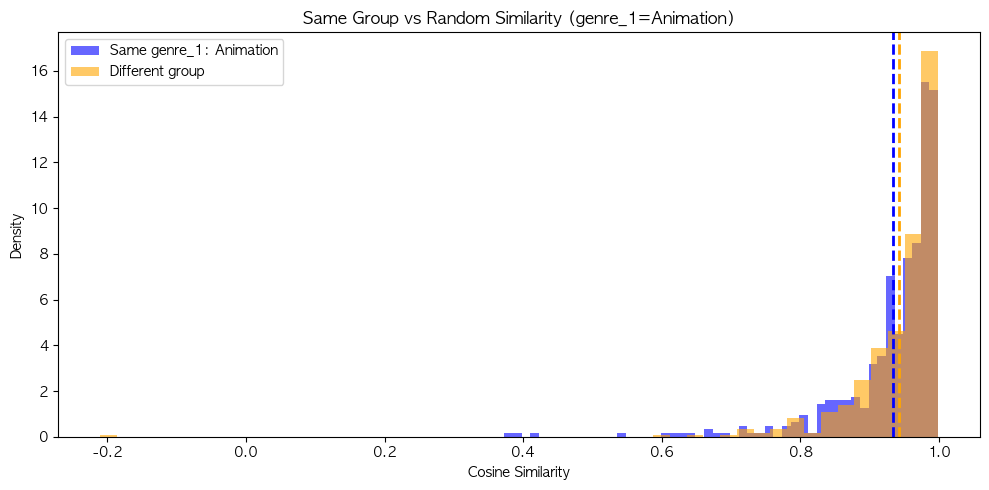


genre_1=Animation:
  그룹 내 평균 유사도: 0.9338 (std: 0.0807)
  다른 그룹 평균 유사도: 0.9423 (std: 0.0777)
  차이: -0.0086


In [39]:
# 주요 장르로 테스트
compare_same_vs_random_similarity('genre_1', 'Animation')

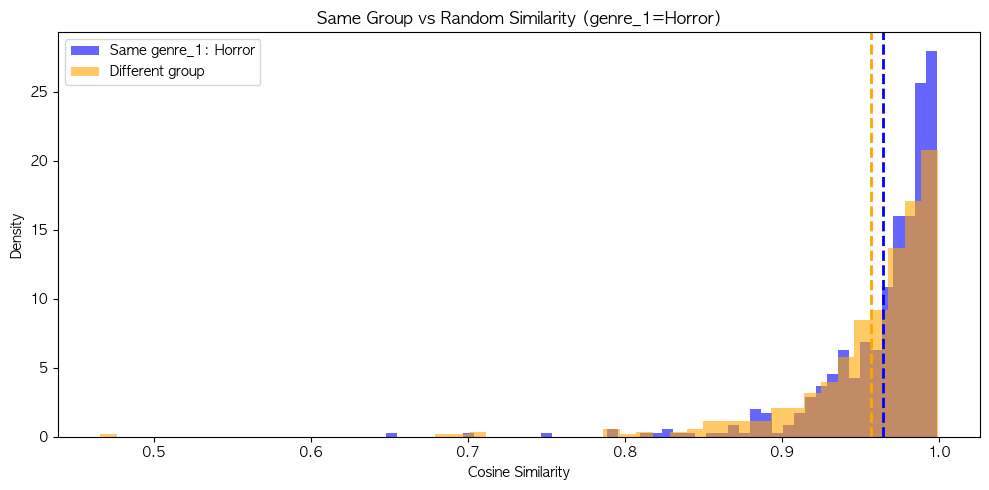


genre_1=Horror:
  그룹 내 평균 유사도: 0.9642 (std: 0.0401)
  다른 그룹 평균 유사도: 0.9564 (std: 0.0502)
  차이: 0.0078


In [40]:
compare_same_vs_random_similarity('genre_1', 'Horror')

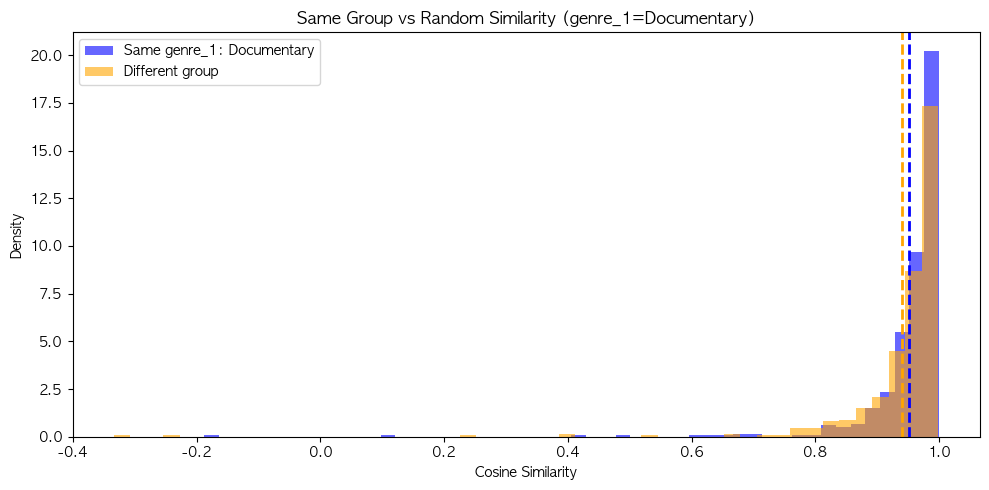


genre_1=Documentary:
  그룹 내 평균 유사도: 0.9520 (std: 0.0878)
  다른 그룹 평균 유사도: 0.9404 (std: 0.1064)
  차이: 0.0117


In [41]:
compare_same_vs_random_similarity('genre_1', 'Documentary')

---
## 9. 요약 및 진단

임베딩 품질에 대한 전반적인 진단을 수행합니다.

In [42]:
print("="*80)
print("임베딩 품질 진단 요약")
print("="*80)

# 1. 기본 통계 요약
print("\n[1] 기본 통계")
print(f"  - 총 영화 수: {len(embeddings):,}")
print(f"  - 임베딩 차원: {embeddings.shape[1]}")
print(f"  - L2 노름 평균: {norms.mean():.4f} (std: {norms.std():.4f})")
print(f"  - 유효 차원 (var > 0.001): {(per_dim_var > 0.001).sum()}")

# 2. 클러스터링 품질
print("\n[2] 클러스터링 품질 (장르 기준)")
print(f"  - Silhouette Score: {sil_score:.4f}")
print(f"  - 평균 그룹 내 유사도: {genre_stats['avg_intra']:.4f}")
print(f"  - 그룹 간 중심 유사도: {genre_stats['inter_similarity']:.4f}")

# 3. 랜덤 유사도
print("\n[3] 랜덤 페어 유사도")
print(f"  - 평균: {random_sims.mean():.4f}")
print(f"  - 표준편차: {random_sims.std():.4f}")

# 4. 품질 판정
print("\n[4] 품질 판정")

issues = []

if random_sims.mean() > 0.95:
    issues.append("⚠️ 랜덤 페어 유사도가 너무 높음 (>0.95) - 임베딩이 충분히 다양하지 않음")
    
if sil_score < 0.1:
    issues.append("⚠️ Silhouette Score가 낮음 (<0.1) - 장르별 클러스터링이 약함")

if genre_stats['avg_intra'] - genre_stats['inter_similarity'] < 0.01:
    issues.append("⚠️ 그룹 내/간 유사도 차이가 작음 - 그룹 분리가 약함")

if (per_dim_var > 0.001).sum() < embeddings.shape[1] * 0.1:
    issues.append("⚠️ 유효 차원이 너무 적음 - 임베딩 용량 활용도 낮음")

if issues:
    print("\n발견된 문제:")
    for issue in issues:
        print(f"  {issue}")
else:
    print("  ✓ 주요 품질 지표 정상")

print("\n" + "="*80)
print("분석 완료!")

임베딩 품질 진단 요약

[1] 기본 통계
  - 총 영화 수: 86,272
  - 임베딩 차원: 300
  - L2 노름 평균: 13.4286 (std: 0.2182)
  - 유효 차원 (var > 0.001): 298

[2] 클러스터링 품질 (장르 기준)
  - Silhouette Score: -0.2800
  - 평균 그룹 내 유사도: 0.9566
  - 그룹 간 중심 유사도: 0.9921

[3] 랜덤 페어 유사도
  - 평균: 0.9505
  - 표준편차: 0.0701

[4] 품질 판정

발견된 문제:
  ⚠️ 랜덤 페어 유사도가 너무 높음 (>0.95) - 임베딩이 충분히 다양하지 않음
  ⚠️ Silhouette Score가 낮음 (<0.1) - 장르별 클러스터링이 약함
  ⚠️ 그룹 내/간 유사도 차이가 작음 - 그룹 분리가 약함

분석 완료!


In [43]:
print("Done!")

Done!
